# Setup

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy
import pickle
from scipy.stats import norm,wilcoxon
import statistics


In [2]:
# import plotly as py
# import plotly.plotly as py
# import plotly.tools as plotly_tools
# import plotly.graph_objs as go
# # from matplotlib.finance import quotes_historical_yahoo
# from IPython.display import HTML

# import plotly.express as px
# fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
# fig.write_html('first_figure.html', auto_open=True)

In [3]:
# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd',
              GOLD = '#FDB119') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

bfill = list(matplotlib.colors.to_rgba(colors['BLUE']))
bfill[-1] = 0.3

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [4]:
a_file = open("HCPS.pkl", "rb") #remember to close afterwards
HCPS = pickle.load(a_file)
a_file.close()

b_file = open("DATA.pkl", "rb") #remember to close afterwards
DATA = pickle.load(b_file)
b_file.close()

c_file = open("TF.pkl", "rb") #remember to close afterwards
TF = pickle.load(c_file)
c_file.close()

d_file = open("SIM.pkl", "rb") #remember to close afterwards
SIM = pickle.load(d_file)
d_file.close()

In [5]:
lqg_file = open("LQG_SIM.pkl", "rb") #remember to close afterwards
LQG_SIM = pickle.load(lqg_file)
lqg_file.close()

In [6]:
# Data analysis
def FFT(data,N):
  return fft.fft(data)/N

def IFFT(data,N):
  return (fft.ifft(data)*N).real
  
M = lambda s : 1/(s**2 + s) #2nd order machine

num_cond = 7 #number of conditions
participants_num = len(HCPS.keys())

#number of trials for each condition
trialnum = [0] * num_cond 
for c in range(num_cond):
  trialnum[c] = len(HCPS['subject0']['condition'+str(c)].keys())         #number of data trials, trial0 ~ trial3

#parameters (same for all three conditions)
fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(HCPS['subject0']['condition0']['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = HCPS['subject0']['condition0']['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers
stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq

T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

<ipython-input-6-cf8719837387>:8: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine
<ipython-input-6-cf8719837387>:8: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine


## plot functions

In [7]:
def boxplot_colors(bp0,bp1,bp2,bp3,bp4,bp5,bp6): # fill in colors
  for i in range(num_cond):
    if i == 0: bp = bp0; box_colors = colors['r']
    elif i == 1: bp = bp1; box_colors = colors['g']
    elif i == 2: bp = bp2; box_colors = colors['u']
    elif i == 3: bp = bp3; box_colors = colors['u25']
    elif i == 4: bp = bp4; box_colors = colors['u75']
    elif i == 5: bp = bp5; box_colors = colors['r']
    else: bp = bp6; box_colors = colors['g']
    num_boxes = 1
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(num_cond):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax.add_patch(Polygon(box_coords, facecolor=box_colors))
    # change color of medians
    for median in bp['medians']: median.set(color ='red')

In [8]:
def BOXPLOT(data0, title0 ,data1 = None, title1 = None, ylimit0 = None, ylimit1= None, EMGplot = False, Sliderplot = False): # can plot one or two plots
    '''
    data0 and data1: list of 7 arrays, [cond0, cond1, ... cond6]
    '''
    
    # pos = np.array(range(num_cond))+1
    # xticks = pos
    # xticklabels = ['Slider','EMG','50%','25%','75%','Slider2','EMG2']
    labels = ['100:0','0:100','50:50','75:25','25:75','100:0','0:100'] #slider : EMG

    boxcolors = ['white', 'black', 'darkgrey','lightgrey','dimgrey','white', 'black',]

    if data1 != None: 
        fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

        # subplot 0
        ax = axs[0]
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
            patch.set_facecolor(color)

        ax.title.set_text(title0)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None: 
            ax.set_ylim(0,ylimit0)
            
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

        # subplot 1
        ax = axs[1]
        bplot = ax.boxplot(data1, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        ax.title.set_text(title1)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit1 is not None:
            ax.set_ylim(0,ylimit1)
        
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

    else: 
        fig,axs = plt.subplots(1, 1,figsize=(5,5)) 
        ax = axs
        # for c in range(num_cond):
        #     bplot = ax.boxplot(data0[c], positions = [pos[c]], widths = 0.5,patch_artist=True)
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        
        # fill with colors
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticklabels)
        ax.title.set_text(title0) #r'$MSE_{time}$'
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None:
            ax.set_ylim(0,ylimit0)

        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)


    # plt.tight_layout()
    # plt.show()
    return fig,axs

In [9]:
#box plot of only 5 elements
def BOXPLOT5(data0, title0 ,data1 = None, title1 = None, ylimit0 = None, ylimit1= None, EMGplot = False, Sliderplot = False): # can plot one or two plots
    '''
    data0 and data1: list of 5 arrays, [cond0, cond1, ... cond4]
    '''
    
    # pos = np.array(range(num_cond))+1
    # xticks = pos
    # xticklabels = ['Slider','EMG','50%','25%','75%','Slider2','EMG2']
    labels = ['100:0','0:100','50:50','75:25','25:75'] #slider : EMG

    boxcolors = ['white', 'black', 'darkgrey','lightgrey','dimgrey']

    if data1 != None: 
        fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

        # subplot 0
        ax = axs[0]
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
            patch.set_facecolor(color)

        ax.title.set_text(title0)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None: 
            ax.set_ylim(0,ylimit0)
            
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

        # subplot 1
        ax = axs[1]
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        ax.title.set_text(title1)
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit1 is not None:
            ax.set_ylim(0,ylimit1)
        
        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

    else: 
        fig,axs = plt.subplots(1, 1,figsize=(5,5)) 
        ax = axs
        # for c in range(num_cond):
        #     bplot = ax.boxplot(data0[c], positions = [pos[c]], widths = 0.5,patch_artist=True)
        bplot = ax.boxplot(data0, widths = 0.5,patch_artist=True,labels=labels)
        
        # fill with colors
        for patch, color in zip(bplot['boxes'], boxcolors):
            patch.set_facecolor(color)

        # ax.set_xticks(xticks)
        # ax.set_xticklabels(xticklabels)
        ax.title.set_text(title0) #r'$MSE_{time}$'
        # ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
        if ylimit0 is not None:
            ax.set_ylim(0,ylimit0)

        ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
        ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)


    # plt.tight_layout()
    # plt.show()
    return fig,axs

In [10]:
def PLOT_BODE(TF, trialnum, figname): 
    #TF is dict
    TF_ = []
    for p in range(participants_num):
        TF_.append(TF['subject'+str(p)])
    TF_ = np.asarray(TF_)    

    # mag & phase
    mag = abs(TF_)
    phase = np.angle(TF_)

    # mean & percentile
    mag_mean = np.mean(mag,axis=0)
    mag_75 = np.percentile(mag, 75, axis=0)
    mag_25 = np.percentile(mag, 25, axis=0)

    phase_mean = np.mean(phase,axis=0)
    phase_75 = np.percentile(phase, 75, axis=0)
    phase_25 = np.percentile(phase, 25, axis=0)

    # plot Tyr and Tyd 
    fig,axs = plt.subplots(2, 1)
    xlim = (stimulated_freq[0]-.01,stimulated_freq[-1]+.1)
    xticks = prime*0.05
    xticklabels =np.round(prime*0.05,2)
    ylimmag = (1e-1,1.5e1)
    yticksmag = [0.1,1,10]
    ylimphase = (-np.pi,np.pi)
    yticksphase = [-np.pi,0.,np.pi]
    yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']

    ax = axs[0]
    for i in range(math.ceil(trialnum/2)):
        ax.plot(stimulated_freq, mag[i], '*--', color='0.8') 
    ax.plot(stimulated_freq, mag_mean, 'o-', color=colors['d'])
    ax.errorbar(x=stimulated_freq, y=mag_mean, xerr=None,
                yerr=np.asarray([mag_mean-mag_25, mag_75-mag_mean]),
                color='k',ls='none',zorder=10)
    ax.plot(xlim,[0.,0.],'k--',zorder=-1)
    ax.set_xscale("log")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlim(xlim)
    # ax.set_ylim(ylimmag)
    ax.set_ylabel('gain')
    # ax.set_yticks(yticksmag) 
    ax.title.set_text(figname) 

    ax = axs[1]
    for i in range(math.ceil(trialnum/2)):
        ax.plot(stimulated_freq, phase[i], '*--', color='0.8') 
    ax.plot(stimulated_freq, phase_mean, 'o-', color=colors['d'])
    ax.errorbar(x=stimulated_freq, y=phase_mean, xerr=None,
                yerr=np.asarray([phase_mean-phase_25, phase_75-phase_mean]),
                color='k',ls='none',zorder=10)
    ax.plot(xlim,[0.,0.],'k--',zorder=-1)
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylimphase)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=90)
    ax.set_ylabel('phase (raidans)')
    ax.set_yticks(yticksphase) 
    ax.set_yticklabels(yticklabelsphase,**font)

    plt.tight_layout()
    plt.show()



## stats tests

In [11]:

# Wilcoxon signed-rank test:  tests the null hypothesis that two related paired samples come from the same distribution

def WilcoxonTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = wilcoxon(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag
#T-test: test for the null hypothesis that two related or repeated samples have identical average (expected) values
def TTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = ttest_rel(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag
# number of trials to look at of each condition: (ex: last 4)
# last_trial = [4,4,8,8,8,4,4]
# last_trial = [2,2,4,4,4,2,2]
# last_trial = [2,2,2,2,2,2,2]
# last_trial = [8,8,10,10,10,2,2]
# last_trial = [5,5,5,5,5,4,4]
last_trial = [5,5,5,5,5,2,2]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
# first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]

# plot_title = 'first 2 freqs' #'all freqs'

# Analysis

## MSE

In [33]:
# number of trials to look at of each condition: (ex: last 4)
# last_trial = [4,4,8,8,8,4,4]
# last_trial = [2,2,4,4,4,2,2]
# last_trial = [8,8,10,10,10,2,2]
last_trial = [4,4,4,4,4,4,4]
# last_trial = [2,2,2,2,2,2,2]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]

plot_title = 'first 2 freqs' #'all freqs'

In [34]:
def MSETIME(last_trial,first_freq):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """

    #(1) MSE time: for every trial for every participant (1 number for each trial)
    MSEt = {}
    for p in range(participants_num): # number of participants = 15
        MSEt['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            r = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][-last_trial[c]:])
            y = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][-last_trial[c]:])
            MSEt['subject'+str(p)]['condition'+str(c)] = np.sum((r-y)**2,axis=1) #time domain error of each trial of each participant

    MSEtvalues = [] # 7 conditions x (15participants * i trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEt['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEtvalues.append(values_)

    return MSEtvalues #average MSE over all trials for every participant

In [1]:
def MSEFREQ(last_trial,first_freq,Ftype):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]

    Ftype = 'F', 'F0', 'F1'
    """

    #(2) MSE freq: for every two trial for every participant (1 number for evry two trial)
    MSEf = {}
    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( ((abs(TF[Ftype]['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):] - 1/M_h[stimulated_index]))**2)[:,first_freq] ,axis=1) 
    
    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    return MSEfvalues #average MSE over all trials for every participant

In [36]:
def MSEFREQ_B(last_trial,first_freq,Btype):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]

    Btype = 'B', 'B0', 'B1'
    """

    #(2) MSE freq: for every two trial for every participant (1 number for evry two trial)
    MSEf = {}
    for p in range(participants_num): # number of participants = 15
        MSEf['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            #freq domain error of every two trials of each participantof every condition
            MSEf['subject'+str(p)]['condition'+str(c)] = np.sum( ((abs(TF[Btype]['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):] - (1-1/M_h[stimulated_index]) ))**2)[:,first_freq] ,axis=1) 
    
    MSEfvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(MSEf['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        MSEfvalues.append(values_)

    return MSEfvalues #average MSE over all trials for every participant

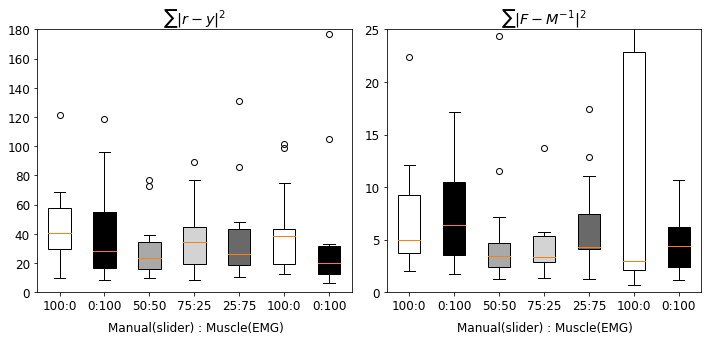

In [37]:
MSEtvalues = MSETIME(last_trial,first_freq)
MSEfvalues = MSEFREQ(last_trial,first_freq,'F')

fig,axs = BOXPLOT(MSEtvalues,'$\sum |r-y|^2$', MSEfvalues,'$\sum |F-M^{-1}|^2$',ylimit0 = 180,ylimit1 = 25)
# fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

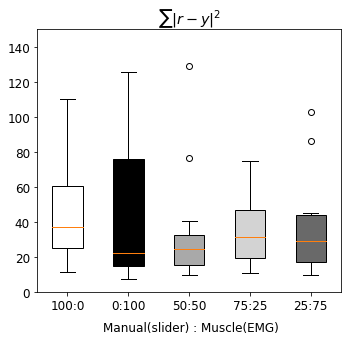

In [234]:
MSEtvalues5 = [(np.array(MSEtvalues[0])+np.array(MSEtvalues[5]))/2, 
                (np.array(MSEtvalues[1])+np.array(MSEtvalues[6]))/2,
                MSEtvalues[2],MSEtvalues[3],MSEtvalues[4]]

fig,axs = BOXPLOT5(MSEtvalues5,'$\sum |r-y|^2$',ylimit0=150)

plt.tight_layout()
plt.show()

In [235]:
w, p = wilcoxon(MSEtvalues5[0],MSEtvalues5[2]) #*
w, p

(16.0, 0.01025390625)

In [236]:
w, p = wilcoxon(MSEtvalues5[0],MSEtvalues5[1])
w, p

(41.0, 0.30279541015625)

In [237]:
w, p = wilcoxon(MSEtvalues5[0],MSEtvalues5[3]) #**
w, p

(13.0, 0.00537109375)

In [238]:
w, p = wilcoxon(MSEtvalues5[0],MSEtvalues5[4])
w, p

(40.0, 0.27685546875)

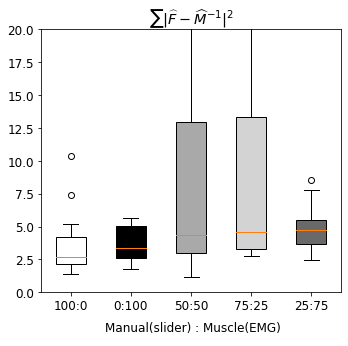

In [239]:
MSEfvalues5 = [(np.array(MSEfvalues[0])+np.array(MSEfvalues[5]))/2, 
                (np.array(MSEfvalues[1])+np.array(MSEfvalues[6]))/2,
                MSEfvalues[2],MSEfvalues[3],MSEfvalues[4]]

fig,axs = BOXPLOT5(MSEfvalues5,'$\sum |\widehat{F}-\widehat{M}^{-1}|^2$',ylimit0=20)

plt.tight_layout()
plt.show()

In [240]:
w, p = wilcoxon(MSEfvalues5[0],MSEfvalues5[2]) 
w, p

(42.0, 0.33026123046875)

## F & B

In [32]:
# number of trials to look at of each condition: (ex: last 4)
# last_trial = [4,4,8,8,8,4,4]
# # last_trial = [2,2,2,2,2,2,2]
# last_trial = [8,8,10,10,10,2,2]
last_trial = [4,4,4,4,4,4,4]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
first_freq = [0,1,2,3,4,5,6,7]
# first_freq = [0,1]


plot_title = 'first 2 freqs' #'all freqs'
plot_title = 'all freqs'

In [18]:
def TF_NORM(last_trial,first_freq,TFtype):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]

    TFtype = 'F', 'F0', 'F1', 'TYR','TYD'...
    """

    # TFnorm: for every two trial for every participant (1 number for evry two trial)
    TFnorm = {}
    for p in range(participants_num): 
        TFnorm['subject'+str(p)] = {}
        for c in range(num_cond): 
            if TFtype == 'TYR' or TFtype == 'TUD': # then calculate TYR-1 or TUD-1
                TFnorm['subject'+str(p)]['condition'+str(c)] = LA.norm(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1,axis = 1)
            else:
            #F of every two trials of each participant of every condition
                TFnorm['subject'+str(p)]['condition'+str(c)] = LA.norm(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq],axis = 1)
    
    TFvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
        TFvalues.append(values_)

    return TFvalues #average MSE over all trials for every participant

In [29]:
def SIM_TF_NORM(last_trial,first_freq,TFtype):
    """
    look at the simulated TF (TY0R,TY0D,TY1R,TY1D) - so only for fusion conditions 

    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]

    TFtype = 'F', 'F0', 'F1', 'TYR','TYD'...
    """

    # TFnorm: for every two trial for every participant (1 number for evry two trial)
    TFnorm = {}
    for p in range(participants_num): 
        TFnorm['subject'+str(p)] = {}
        for c in [2,3,4]: 
            if TFtype == 'TYR' or TFtype == 'TUD': # then calculate TYR-1 or TUD-1
                TFnorm['subject'+str(p)]['condition'+str(c)] = LA.norm(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq]-1,axis = 1)
            else:
            #F of every two trials of each participant of every condition
                TFnorm['subject'+str(p)]['condition'+str(c)] = LA.norm(TF[TFtype]['subject'+str(p)]['condition'+str(c)][-(last_trial[2]//2):][:,first_freq],axis = 1)
    
    TFvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in [2,3,4]: 
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(TFnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
        TFvalues.append(values_)

    return TFvalues #average MSE over all trials for every participant

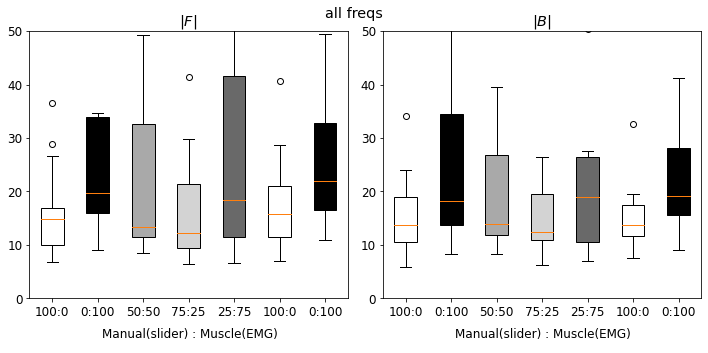

In [32]:
Fvalues = TF_NORM(last_trial,first_freq,'F')
Bvalues = TF_NORM(last_trial,first_freq,'B')

fig,axs = BOXPLOT(Fvalues,'$|F|$', Bvalues,'$|B|$',ylimit0 = 50,ylimit1 = 50)
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

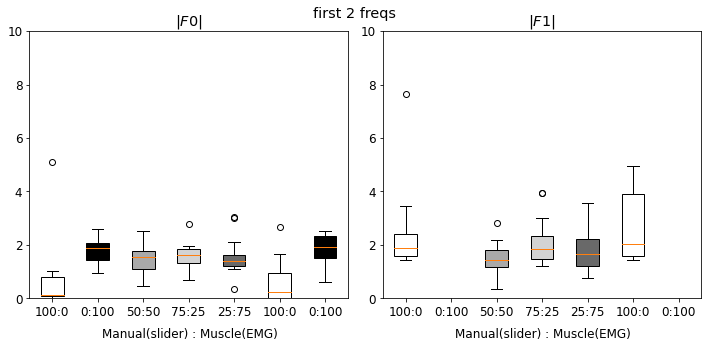

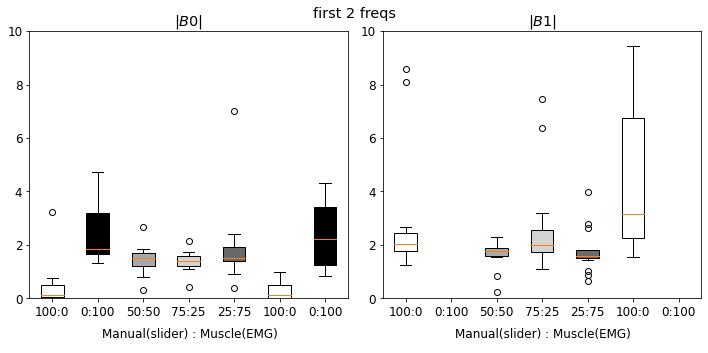

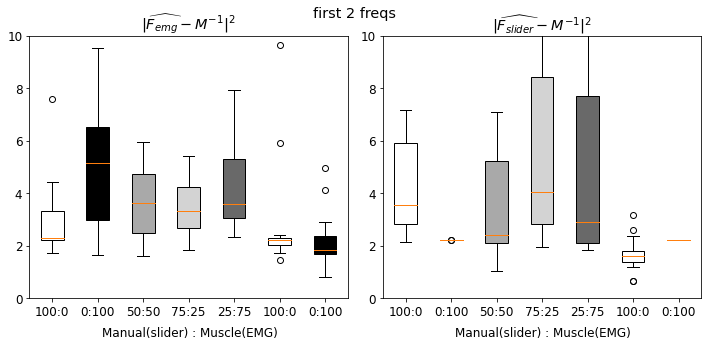

In [245]:
F0values = TF_NORM(last_trial,first_freq,'F0')
B0values = TF_NORM(last_trial,first_freq,'B0')
F1values = TF_NORM(last_trial,first_freq,'F1')
B1values = TF_NORM(last_trial,first_freq,'B1')

MSEf0values = MSEFREQ(last_trial,first_freq,'F0')
MSEf1values = MSEFREQ(last_trial,first_freq,'F1')

fig,axs = BOXPLOT(F0values,'$|F0|$', F1values,'$|F1|$',ylimit0 = 10,ylimit1 = 10)
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

fig,axs = BOXPLOT(B0values,'$|B0|$', B1values,'$|B1|$',ylimit0 = 10,ylimit1 = 10)
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

fig,axs = BOXPLOT(MSEf0values,'$|\widehat{F_{emg}} - M^{-1}|^{2}$',MSEf1values,'$|\widehat{F_{slider}}- M^{-1}|^{2}$',ylimit0 =10,ylimit1 =10)
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

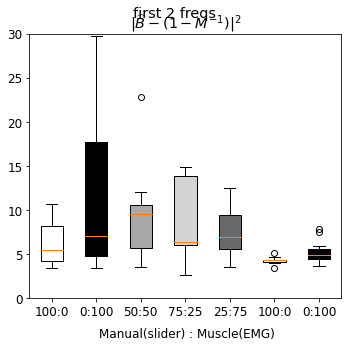

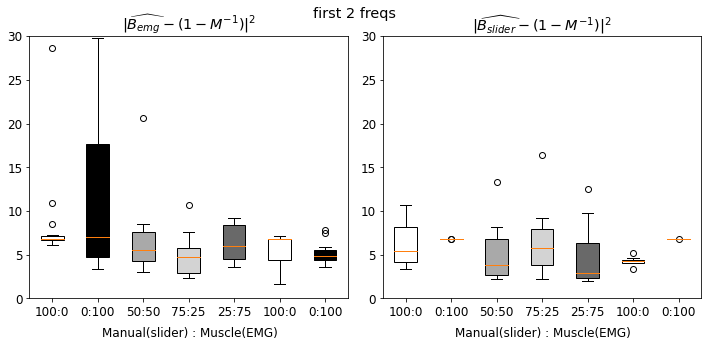

In [246]:
MSEBvalues = MSEFREQ_B(last_trial,first_freq,'B')
MSEB0values = MSEFREQ_B(last_trial,first_freq,'B0')
MSEB1values = MSEFREQ_B(last_trial,first_freq,'B1')

fig,axs = BOXPLOT(MSEBvalues ,'$|\widehat{B} - (1-M^{-1})|^{2}$',ylimit0=30)
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

fig,axs = BOXPLOT(MSEB0values,'$|\widehat{B_{emg}} - (1-M^{-1})|^{2}$',MSEB1values,'$|\widehat{B_{slider}}- (1-M^{-1})|^{2}$',ylimit0=30,ylimit1=30)
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

## F/B Bode plots

In [19]:
def PLOT_FB_BODE(c, last_trial): 
    xlim = (stimulated_freq[0]-.01,stimulated_freq[-1]+.1)
    xticks = prime*0.05
    xticklabels =np.round(prime*0.05,2)
    # ylimmag = (1e-1,1.5e1)
    ylimmag = (1e-1,10**2)
    yticksmag = [0.1,1.0,10.0]
    yticklabelsmag = ['0.1','1.0','10.0']
    ylimphase = (-np.pi-0.1,np.pi+1.8)
    yticksphase = [-np.pi,0.,np.pi]
    yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']

    # # plot
    # fig=plt.figure()
    # ax1 = plt.subplot(221)
    # ax2 = plt.subplot(222, sharey = ax1)
    # ax3 = plt.subplot(223)
    # ax4 = plt.subplot(224, sharey = ax3)

    fig,axs = plt.subplots(2, 2,sharex=True,figsize=(8,4))

    for j in [0,1]:
        if j==0:
            FBType = 'B'
        else:
            FBType = 'F'

        mag_mean = []
        phase_mean = []
        for p in range(participants_num):
            # mag & phase of all trials
            mag = np.abs(TF[FBType]['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):])
            phase = np.angle(TF[FBType]['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):])

            mag_mean.append( np.mean(mag,axis=0) ) #average of all trials
            phase_mean.append( np.angle( np.mean(np.exp(1j*phase), axis=0)) ) #average of all trials

        # average mag of all participants (15 numbers)
        mag_mean_mean = np.mean(mag_mean,axis=0)
        mag_mean_75 = np.percentile(mag_mean, 75, axis=0)
        mag_mean_25 = np.percentile(mag_mean, 25, axis=0)

        # average phase of all participants (15 numbers)
        if j==0:
            z = np.mean(np.exp(1j*(np.asarray(phase_mean))), axis=0)
            phase_mean_mean = np.angle(z)
            phase_mean_disp = 1-np.abs(z)
        else:
            z = np.mean(np.exp(1j*(np.asarray(phase_mean)-np.pi)), axis=0)
            phase_mean_mean = np.angle(z)+np.pi
            phase_mean_disp = 1-np.abs(z)

        ax = axs[0,j]
        # for i in range(math.ceil(trialnum[c]/2)):
        #     ax.plot(stimulated_freq, np.asarray(mag_mean)[i], '*--', color='0.8') 
        ax.plot(stimulated_freq, mag_mean_mean, 'o-', color=colors['d'])
        # ax.errorbar(x=stimulated_freq, y=mag_mean_mean, xerr=None,
        #             yerr=np.asarray([mag_mean_mean-mag_mean_25, mag_mean_75-mag_mean_mean]),
        #             color='k',ls='none',zorder=10)
        ax.fill_between(stimulated_freq, mag_mean_25, mag_mean_75,
                                facecolor=colors['d'],edgecolor=colors['d'],alpha = 0.3)
        # ax.plot(xlim,[0.,0.],'k--',zorder=-1)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlim(xlim)
        ax.set_ylim(ylimmag)
        ax.set_yticks(yticksmag) 
        ax.set_yticklabels(yticklabelsmag,**font)
        # ax.title.set_text()
        ax.grid('on',zorder=-1)

        ax = axs[1,j]
        # for i in range(math.ceil(trialnum[c]/2)):
        #     ax.plot(stimulated_freq, phase_mean[i], '*--', color='0.8') 
        ax.plot(stimulated_freq, phase_mean_mean, 'o-', color=colors['d'],label=FBType)
        # ax.errorbar(x=stimulated_freq, y=phase_mean_mean, xerr=None,
        #             yerr=np.asarray([phase_mean_disp, phase_mean_disp]),
        #             color='k',ls='none',zorder=10)
        ax.fill_between(stimulated_freq, phase_mean_mean+phase_mean_disp,phase_mean_mean-phase_mean_disp,
                                facecolor=colors['d'],edgecolor=colors['d'],alpha = 0.3)
        
        # ax.plot(xlim,[np.pi,np.pi],'k--',zorder=-1,alpha = 0.5)
        ax.set_xscale("log")
        ax.set_xlim(xlim)
        ax.set_ylim(ylimphase)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels,rotation=90)
        ax.set_yticks(yticksphase) 
        ax.set_yticklabels(yticklabelsphase,**font)
        ax.grid('on',zorder=-1)
        

    ax = axs[0,0]
    ax.set_ylabel('gain')

    ax = axs[1,0]
    ax.set_ylabel('phase (raidans)')
    ax.legend(loc='lower center',ncol=2,frameon=False)

    ax = axs[0,1]
    ax.plot(stimulated_freq,np.abs(1/M_h[stimulated_index]), 'o-', color='black') # M^-1
    ax = axs[1,1]
    ax.plot(stimulated_freq,np.angle(1/M_h[stimulated_index]), 'o-', color='black',label=r'$M^{-1}$') # M^-1
    ax.legend(loc='lower center',ncol=2,frameon=False)

    plt.tight_layout()
    fig.suptitle('condition '+str(c)) 
    plt.show()



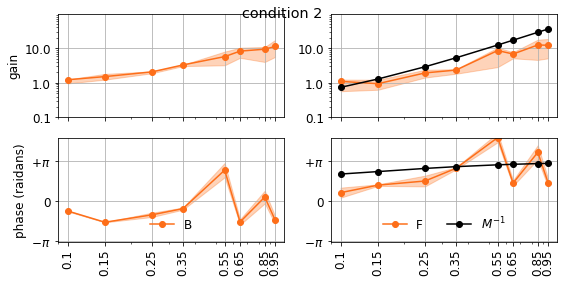

In [31]:
# last_trial = [5,5,5,5,5,2,2]
last_trial = [4,4,4,4,4,4,4]
PLOT_FB_BODE(2,last_trial)

## Tyr TyMD Bode Plots

In [29]:
def PLOT_T_BODE(c, last_trial): 
    xlim = (stimulated_freq[0]-.01,stimulated_freq[-1]+.1)
    xticks = prime*0.05
    xticklabels =np.round(prime*0.05,2)
    # ylimmag = (1e-1,1.5e1)
    ylimmag = (1e-1,10**2)
    yticksmag = [0.1,1.0,10.0]
    yticklabelsmag = ['0.1','1.0','10.0']
    ylimphase = (-np.pi-0.1,np.pi+1.8)
    yticksphase = [-np.pi,0.,np.pi]
    yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']

    # # plot
    # fig=plt.figure()
    # ax1 = plt.subplot(221)
    # ax2 = plt.subplot(222, sharey = ax1)
    # ax3 = plt.subplot(223)
    # ax4 = plt.subplot(224, sharey = ax3)

    fig,axs = plt.subplots(2, 2,sharex=True,figsize=(8,4))

    for j in [0,1]:
        if j==0:
            FBType = 'TYR'
        else:
            FBType = 'TYMD'

        mag_mean = []
        phase_mean = []
        for p in range(participants_num):
            # mag & phase of all trials
            mag = np.abs(TF[FBType]['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):])
            phase = np.angle(TF[FBType]['subject'+str(p)]['condition'+str(c)][-(last_trial[c]//2):])

            mag_mean.append( np.mean(mag,axis=0) ) #average of all trials
            phase_mean.append( np.angle( np.mean(np.exp(1j*phase), axis=0)) ) #average of all trials

        # average mag of all participants (15 numbers)
        mag_mean_mean = np.mean(mag_mean,axis=0)
        mag_mean_75 = np.percentile(mag_mean, 75, axis=0)
        mag_mean_25 = np.percentile(mag_mean, 25, axis=0)

        # average phase of all participants (15 numbers)
        if j==0:
            z = np.mean(np.exp(1j*(np.asarray(phase_mean))), axis=0)
            phase_mean_mean = np.angle(z)
            phase_mean_disp = 1-np.abs(z)
        else:
            z = np.mean(np.exp(1j*(np.asarray(phase_mean)-np.pi)), axis=0)
            phase_mean_mean = np.angle(z)+np.pi
            phase_mean_disp = 1-np.abs(z)

        ax = axs[0,j]
        # for i in range(math.ceil(trialnum[c]/2)):
        #     ax.plot(stimulated_freq, np.asarray(mag_mean)[i], '*--', color='0.8') 
        ax.plot(stimulated_freq, mag_mean_mean, 'o-', color=colors['d'])
        # ax.errorbar(x=stimulated_freq, y=mag_mean_mean, xerr=None,
        #             yerr=np.asarray([mag_mean_mean-mag_mean_25, mag_mean_75-mag_mean_mean]),
        #             color='k',ls='none',zorder=10)
        ax.fill_between(stimulated_freq, mag_mean_25, mag_mean_75,
                                facecolor=colors['d'],edgecolor=colors['d'],alpha = 0.3)
        # ax.plot(xlim,[0.,0.],'k--',zorder=-1)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlim(xlim)
        ax.set_ylim(ylimmag)
        ax.set_yticks(yticksmag) 
        ax.set_yticklabels(yticklabelsmag,**font)
        # ax.title.set_text()
        ax.grid('on',zorder=-1)

        ax = axs[1,j]
        # for i in range(math.ceil(trialnum[c]/2)):
        #     ax.plot(stimulated_freq, phase_mean[i], '*--', color='0.8') 
        ax.plot(stimulated_freq, phase_mean_mean, 'o-', color=colors['d'],label=FBType)
        # ax.errorbar(x=stimulated_freq, y=phase_mean_mean, xerr=None,
        #             yerr=np.asarray([phase_mean_disp, phase_mean_disp]),
        #             color='k',ls='none',zorder=10)
        ax.fill_between(stimulated_freq, phase_mean_mean+phase_mean_disp,phase_mean_mean-phase_mean_disp,
                                facecolor=colors['d'],edgecolor=colors['d'],alpha = 0.3)
        
        # ax.plot(xlim,[np.pi,np.pi],'k--',zorder=-1,alpha = 0.5)
        ax.set_xscale("log")
        ax.set_xlim(xlim)
        # ax.set_ylim(ylimphase)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels,rotation=90)
        ax.set_yticks(yticksphase) 
        ax.set_yticklabels(yticklabelsphase,**font)
        ax.grid('on',zorder=-1)
        

    ax = axs[0,0]
    ax.set_ylabel('gain')

    ax = axs[1,0]
    ax.set_ylabel('phase (raidans)')
    ax.legend(loc='lower center',ncol=2,frameon=False)

    # ax = axs[0,1]
    # ax.plot(stimulated_freq,np.abs(1/M_h[stimulated_index]), 'o-', color='black') # M^-1
    ax = axs[1,1]
    # ax.plot(stimulated_freq,np.angle(1/M_h[stimulated_index]), 'o-', color='black',label=r'$M^{-1}$') # M^-1
    ax.legend(loc='lower center',ncol=2,frameon=False)

    plt.tight_layout()
    fig.suptitle('condition '+str(c)) 
    plt.show()



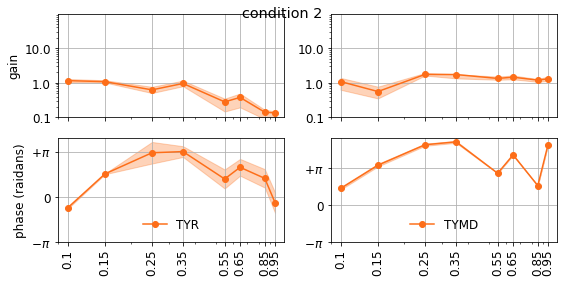

In [30]:
last_trial = [4,4,4,4,4,4,4]
PLOT_T_BODE(2,last_trial)

## stats functions

In [ ]:
# Wilcoxon signed-rank test:  tests the null hypothesis that two related paired samples come from the same distribution

def WilcoxonTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = wilcoxon(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

In [ ]:
#T-test: test for the null hypothesis that two related or repeated samples have identical average (expected) values
def TTest(all_data):
    n = len(all_data)
    w = np.zeros(n**2)
    p = np.zeros(n**2)
    sig = np.zeros(n**2)
    flag = []
    k = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                w[k], p[k] = ttest_rel(all_data[i],all_data[j])
                # determine significant (p<=0.05)
                if p[k] <= 0.05:
                    sig[k] = 1
            else: 
                w[k] = np.nan
                p[k] = np.nan
                sig[k] = np.nan #i=j
            
            if sig[k] == 1 and j > i:
                flag.append('there is significant difference between condition '+str(i)+' and condition '+str(j)+', w = '+str(w[k])+ ', pvalue = '+str(p[k]))
            
            k+=1    
    return w,p,sig,flag

In [ ]:
# number of trials to look at of each condition: (ex: last 4)
# last_trial = [4,4,8,8,8,4,4]
# last_trial = [2,2,4,4,4,2,2]
# last_trial = [2,2,2,2,2,2,2]
# last_trial = [8,8,10,10,10,2,2]
# last_trial = [5,5,5,5,5,4,4]
last_trial = [5,5,5,5,5,2,2]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
# first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]

# plot_title = 'first 2 freqs' #'all freqs'

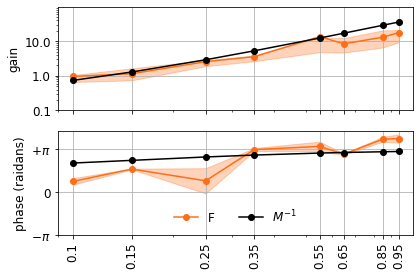

In [563]:
PLOT_FB_BODE(1, 'F',last_trial)

## TUR & TUD

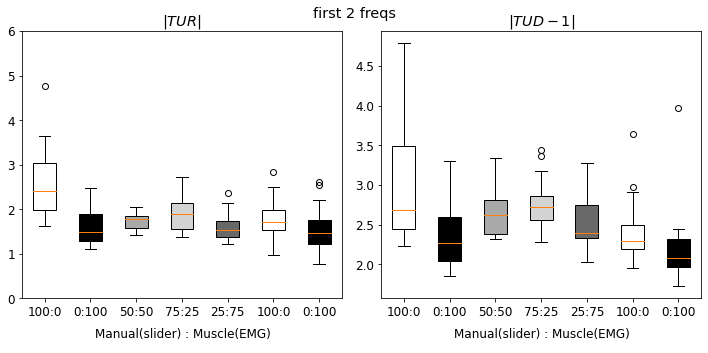

In [248]:
TURvalues = TF_NORM(last_trial,first_freq,'TUR')
TUDvalues = TF_NORM(last_trial,first_freq,'TUD')

fig,axs = BOXPLOT(TURvalues,'$|TUR|$', TUDvalues,'$|TUD - 1|$',ylimit0 = 6)
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

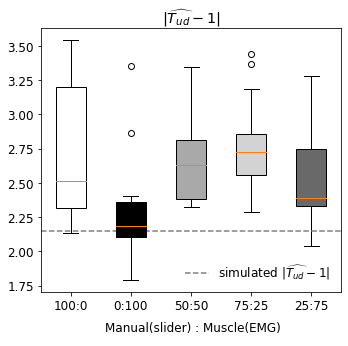

In [249]:
TUDvalues5 = [(np.array(TUDvalues[0])+np.array(TUDvalues[5]))/2, 
                (np.array(TUDvalues[1])+np.array(TUDvalues[6]))/2,
                TUDvalues[2],TUDvalues[3],TUDvalues[4]]
TUDsim = LA.norm(LQG_SIM['Tud'][first_freq] - 1)

fig,axs = BOXPLOT5(TUDvalues5,'$|\widehat{T_{ud}} - 1|$')
# fig.suptitle(plot_title)
hline = plt.axhline(y=TUDsim,color='grey',linestyle = '--',label='simulated Tud')
from matplotlib.legend import Legend
legend1 = Legend(axs,[hline], [r'simulated $|\widehat{T_{ud}} - 1|$'],loc='lower right',frameon=False)
axs.add_artist(legend1)

plt.tight_layout()
plt.show()

In [250]:
w, p = wilcoxon(TUDvalues5[0],TUDvalues5[1]) #**
w,p

(14.0, 0.0067138671875)

In [251]:
w, p = wilcoxon(TUDvalues5[1],TUDvalues5[2]) #**
w,p

(12.0, 0.0042724609375)

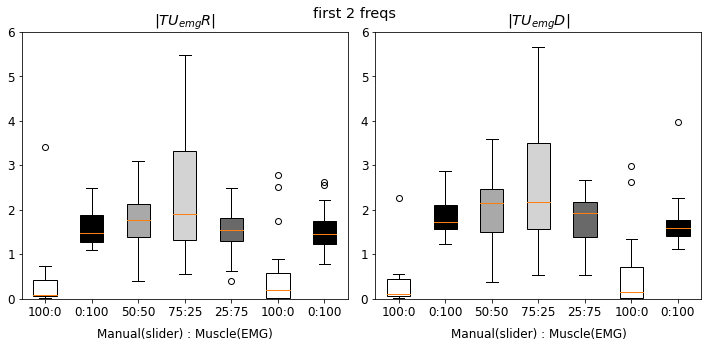

In [252]:
TU0Rvalues = TF_NORM(last_trial,first_freq,'TU0R')
TU0Dvalues = TF_NORM(last_trial,first_freq,'TU0D')

fig,axs = BOXPLOT(TU0Rvalues,'$|TU_{emg}R|$', TU0Dvalues,'$|TU_{emg}D|$',ylimit0 = 6,ylimit1 = 6)
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

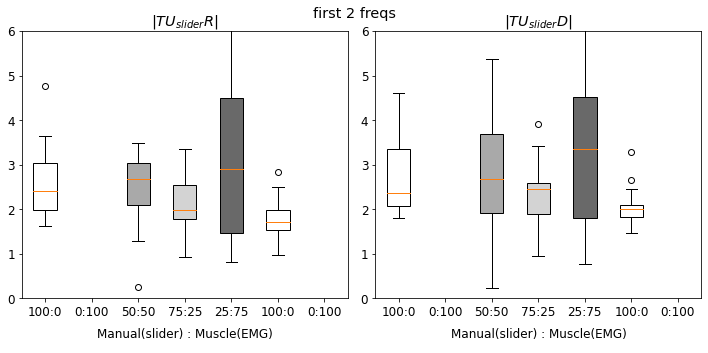

In [253]:
TU1Rvalues = TF_NORM(last_trial,first_freq,'TU1R')
TU1Dvalues = TF_NORM(last_trial,first_freq,'TU1D')

fig,axs = BOXPLOT(TU1Rvalues,'$|TU_{slider}R|$', TU1Dvalues,'$|TU_{slider}D|$',ylimit0 = 6,ylimit1 = 6)
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

## TYR & TYD

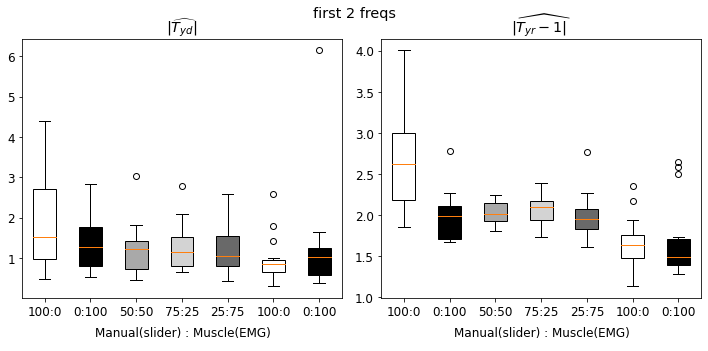

In [254]:
TYRvalues = TF_NORM(last_trial,first_freq,'TYR')
TYDvalues = TF_NORM(last_trial,first_freq,'TYD')

fig,axs = BOXPLOT(TYDvalues,'$|\widehat{T_{yd}}|$',TYRvalues,'$\widehat{|T_{yr}-1}|$')
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

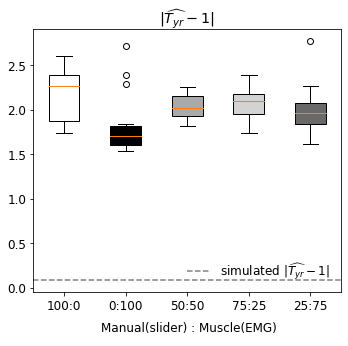

In [255]:
TYRvalues5 = [(np.array(TYRvalues[0])+np.array(TYRvalues[5]))/2, 
                (np.array(TYRvalues[1])+np.array(TYRvalues[6]))/2,
                TYRvalues[2],TYRvalues[3],TYRvalues[4]]
TYRsim = LA.norm(LQG_SIM['Tyr'][first_freq] - 1) #Tyr-1

fig,axs = BOXPLOT5(TYRvalues5,'$|\widehat{T_{yr}} - 1|$')
# fig.suptitle(plot_title)
hline = plt.axhline(y=TYRsim,color='grey',linestyle = '--',label='simulated Tyr')
from matplotlib.legend import Legend
legend1 = Legend(axs,[hline], [r'simulated $|\widehat{T_{yr}} - 1|$'],loc='lower right',frameon=False)
axs.add_artist(legend1)

plt.tight_layout()
plt.show()

In [256]:
w, p = wilcoxon(TYRvalues5[0],TYRvalues5[1]) #***
w,p

(6.0, 0.0008544921875)

In [257]:
w, p = wilcoxon(TYRvalues5[0],TYRvalues5[2])
w,p

(40.0, 0.27685546875)

In [258]:
w, p = wilcoxon(TYRvalues5[0],TYRvalues5[3])
w,p

(49.0, 0.5614013671875)

In [259]:
w, p = wilcoxon(TYRvalues5[0],TYRvalues5[4])
w,p

(28.0, 0.072998046875)

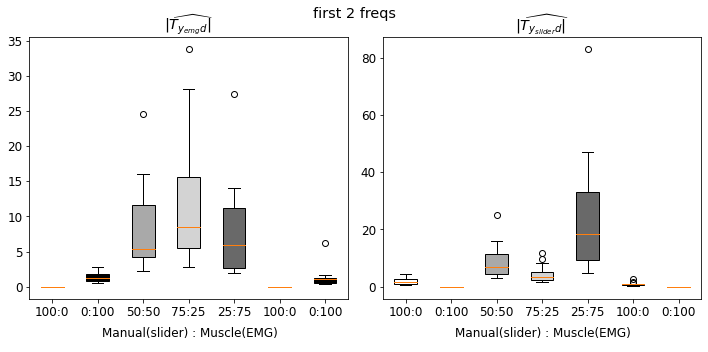

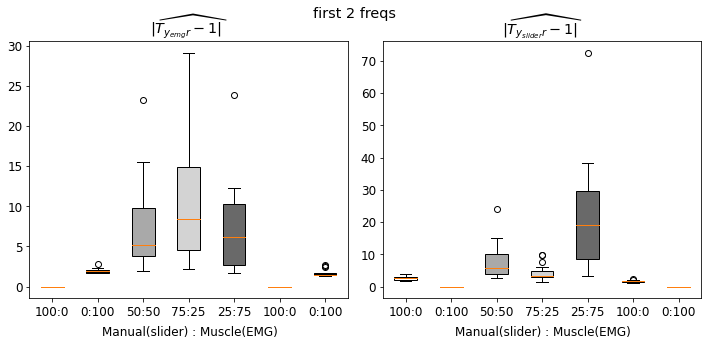

In [260]:
TY0Rvalues = SIM_TF_NORM(last_trial,first_freq,'TY0R')
TY0Dvalues = SIM_TF_NORM(last_trial,first_freq,'TY0D')

TY1Rvalues = SIM_TF_NORM(last_trial,first_freq,'TY1R')
TY1Dvalues = SIM_TF_NORM(last_trial,first_freq,'TY1D')

fig,axs = BOXPLOT([[0],TYDvalues[1],TY0Dvalues[0],TY0Dvalues[1],TY0Dvalues[2],[0],TYDvalues[6]],'$|\widehat{T_{y_{emg}d}}|$',
                  [TYDvalues[0],[0],TY1Dvalues[0],TY1Dvalues[1],TY1Dvalues[2],TYDvalues[5],[0]],'$|\widehat{T_{y_{slider}d}}|$',
                  )
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()
fig,axs = BOXPLOT([[0],TYRvalues[1],TY0Rvalues[0],TY0Rvalues[1],TY0Rvalues[2],[0],TYRvalues[6]],'$\widehat{|T_{y_{emg}r}-1}|$',
                  [TYRvalues[0],[0],TY1Rvalues[0],TY1Rvalues[1],TY1Rvalues[2],TYRvalues[5],[0]],'$\widehat{|T_{y_{slider}r}-1}|$',
                  )
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()

# User inputs

## U & UX

In [392]:
#mask for index of freq that are less than 1Hz
def lessthanone(x): return x <= 1.0
indexone = [idx for idx, element in enumerate(xf) if lessthanone(element)]
unwanted_index = {4, 6, 10, 14, 22, 26, 34, 38}
nonstimulated_index = [i for i in indexone if i not in unwanted_index]

In [640]:
# last_trial = [8,8,10,10,10,2,2]
# last_trial = [2,2,2,2,2,2,2]
last_trial = [4,4,4,4,4,4,4]


# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
# first_freq = [0,1,2,3,4,5,6,7]
first_freq = [0,1]


In [662]:
def U_NORM(last_trial,Utype):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    Utype = 'U', 'U0', 'U1'
    """

    Unorm = {}
    for p in range(participants_num): 
        Unorm['subject'+str(p)] = {}
        for c in range(num_cond): 
            U_less1 = np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)][Utype][-last_trial[c]:]) # all trials, u values less than 1Hz
            if Utype == 'U' or Utype == 'U0' or Utype == 'U1':
                Unorm['subject'+str(p)]['condition'+str(c)] = LA.norm(U_less1[:,indexone],axis =1) #2-norm of U of every trial
            else:  #"UX" already less than 1Hz
                Unorm['subject'+str(p)]['condition'+str(c)] = LA.norm(U_less1,axis =1) #2-norm of U of every trial


    Uvalues = [] # 7 conditions x (15participants * i/2 trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(Unorm['subject'+str(p)]['condition'+str(c)])) 
        Uvalues.append(values_)

    Uvalues5 = [] # 5 conditions x (15participants * i/2 trials)
    for c in range(num_cond-2):
        values_ = []
        for p in range(participants_num):
            if c==0:
                values_.append(np.mean(np.concatenate([Unorm['subject'+str(p)]['condition'+str(c)],Unorm['subject'+str(p)]['condition'+str(5)]])))
            elif c==1:
                values_.append(np.mean(np.concatenate([Unorm['subject'+str(p)]['condition'+str(c)],Unorm['subject'+str(p)]['condition'+str(6)]])))
            else:
                values_.append(np.mean(Unorm['subject'+str(p)]['condition'+str(c)])) 
        Uvalues5.append(values_)

    return Uvalues,Uvalues5

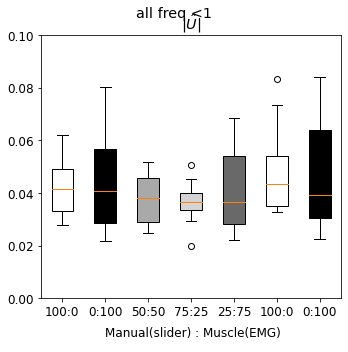

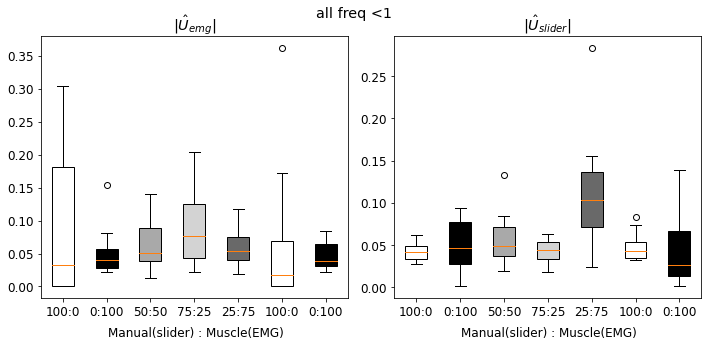

In [663]:
Uvalues,Uvalues5 = U_NORM(last_trial,'U')
U0values,Uvalues5 = U_NORM(last_trial,'U0')
U1values,Uvalues5 = U_NORM(last_trial,'U1')

fig,axs = BOXPLOT(Uvalues,'$|\hat{U}|$',ylimit0 = 0.1)
fig.suptitle('all freq <1')
plt.tight_layout()
plt.show()

fig,axs = BOXPLOT(U0values,'$|\hat{U}_{emg}|$',U1values,'$|\hat{U}_{slider}|$')
fig.suptitle('all freq <1')
plt.tight_layout()
plt.show()

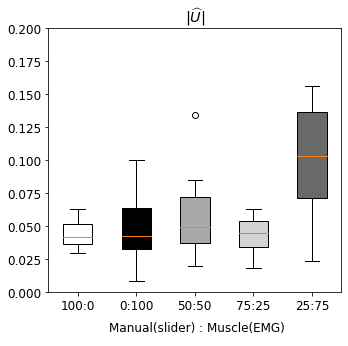

In [643]:
# Uvalues5 = [(np.array(Uvalues[0])+np.array(Uvalues[5]))/2, 
#                 (np.array(Uvalues[1])+np.array(Uvalues[6]))/2,
#                 Uvalues[2],Uvalues[3],Uvalues[4]]
fig,axs = BOXPLOT5(Uvalues5,'$|\widehat{U}|$',ylimit0=0.2)
plt.tight_layout()
plt.show()

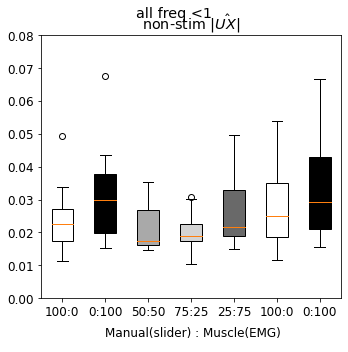

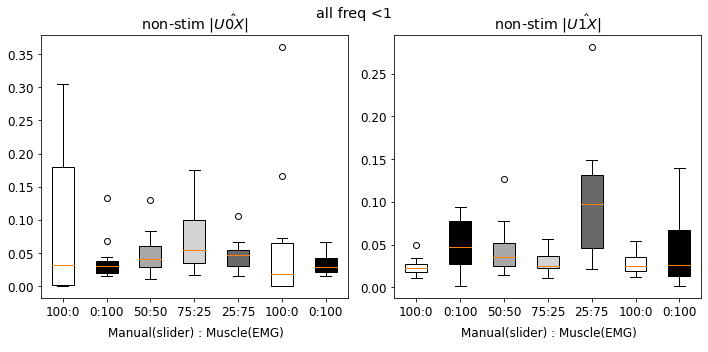

In [664]:
UXvalues,Uvalues5 = U_NORM(last_trial,'UX')
U0Xvalues,Uvalues5 = U_NORM(last_trial,'U0X')
U1Xvalues,Uvalues5 = U_NORM(last_trial,'U1X')

fig,axs = BOXPLOT(UXvalues,'non-stim $|\hat{UX}|$',ylimit0 = 0.08)
fig.suptitle('all freq <1')
plt.tight_layout()
plt.show()

fig,axs = BOXPLOT(U0Xvalues,'non-stim $|\hat{U0X}|$',U1Xvalues,'non-stim $|\hat{U1X}|$')
fig.suptitle('all freq <1')
plt.tight_layout()
plt.show()

In [665]:
w,pv,sig,flag = WilcoxonTest(UXvalues)
flag

['there is significant difference between condition 0 and condition 6, w = 22.0, pvalue = 0.0301513671875',
 'there is significant difference between condition 1 and condition 2, w = 13.0, pvalue = 0.00537109375',
 'there is significant difference between condition 1 and condition 3, w = 16.0, pvalue = 0.01025390625',
 'there is significant difference between condition 2 and condition 6, w = 10.0, pvalue = 0.00262451171875',
 'there is significant difference between condition 3 and condition 4, w = 23.0, pvalue = 0.03533935546875',
 'there is significant difference between condition 3 and condition 5, w = 23.0, pvalue = 0.03533935546875',
 'there is significant difference between condition 3 and condition 6, w = 5.0, pvalue = 0.0006103515625']

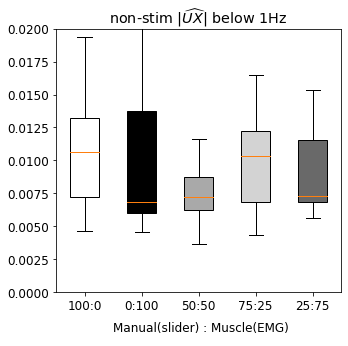

In [645]:
# UXvalues5 = [(np.array(UXvalues[0])+np.array(UXvalues[5]))/2, 
#                 (np.array(UXvalues[1])+np.array(UXvalues[6]))/2,
#                 UXvalues[2],UXvalues[3],UXvalues[4]]
#                 # do append
fig,axs = BOXPLOT5(UXvalues5,'non-stim $|\widehat{UX}|$ below 1Hz',ylimit0=0.02)
plt.tight_layout()
plt.show()

In [430]:
w, p = wilcoxon(UXvalues5[2],UXvalues5[0]) 
w, p

(8.0, 0.00152587890625)

## UX below corssover freq

In [646]:
# UX below corssover
UXnorm = {}
for p in range(participants_num): 
    UXnorm['subject'+str(p)] = {}
    for c in range(num_cond): 
        UX_cross = np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['UX'][-last_trial[c]:])[:,:8]) #average UX below corssover of all trials 
        UXnorm['subject'+str(p)]['condition'+str(c)] = LA.norm(UX_cross,axis = 1) 

UXvalues = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        values_.append(np.mean(UXnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
    UXvalues.append(values_) #each participant 

UXvalues5 = [] # 5 conditions x (15participants * i/2 trials)
for c in range(num_cond-2):
    values_ = []
    for p in range(participants_num):
        if c ==0:
            values_.append(np.mean(np.concatenate([UXnorm['subject'+str(p)]['condition'+str(c)],UXnorm['subject'+str(p)]['condition'+str(5)]])))
        elif c ==1:
            values_.append(np.mean(np.concatenate([UXnorm['subject'+str(p)]['condition'+str(c)],UXnorm['subject'+str(p)]['condition'+str(6)]])))
        else:
            values_.append(np.mean(UXnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
    UXvalues5.append(values_) #each participant 

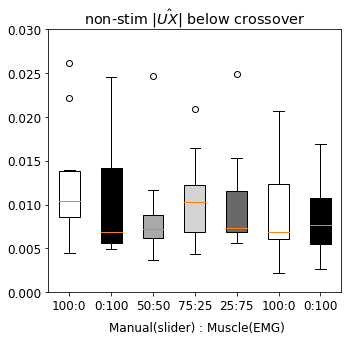

In [647]:
# UXvalues,Uvalues5 = U_NORM(last_trial,'UX')
# U0Xvalues,Uvalues5 = U_NORM(last_trial,'U0X')
# U1Xvalues,Uvalues5 = U_NORM(last_trial,'U1X')

fig,axs = BOXPLOT(UXvalues,'non-stim $|\hat{UX}|$ below crossover',ylimit0=0.03)
# fig.suptitle('non-stim UX below corssover')
plt.tight_layout()
plt.show()

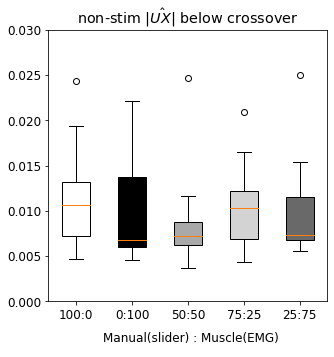

In [648]:
# UXvalues5 = [(np.array(UXvalues[0])+np.array(UXvalues[5]))/2, 
#                 (np.array(UXvalues[1])+np.array(UXvalues[6]))/2,
#                 UXvalues[2],UXvalues[3],UXvalues[4]]

fig,axs = BOXPLOT5(UXvalues5,'non-stim $|\hat{UX}|$ below crossover',ylimit0=0.03)

In [649]:
w, p = wilcoxon(UXvalues5[2],UXvalues5[4]) 
w, p

(31.0, 0.10699462890625)

## all UX

In [13]:
#mask for index of freq that are less than 1Hz
def lessthanone(x): return x <= 1.0
indexone = [idx for idx, element in enumerate(xf) if lessthanone(element)]
unwanted_index = {4,  6, 10, 14, 22, 26, 34, 38}
nonstimulated_index = [i for i in indexone if i not in unwanted_index]
all_nonstimulated_index = [i for i in range(N//2) if i not in unwanted_index]
# normalize_UX = 1/(xf_all[all_nonstimulated_index]**2)
# normalize_UX[0] = 0

In [14]:
last_trial = [4,4,4,4,4,4,4]

In [21]:
# UX below corssover
UXnorm = {}
for p in range(participants_num): 
    UXnorm['subject'+str(p)] = {}
    for c in range(num_cond): 
        UX_all = np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:])[:,all_nonstimulated_index]) #average UX of all trials 
        UXnorm['subject'+str(p)]['condition'+str(c)] = LA.norm(UX_all,axis = 1)

UXvalues = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        values_.append(np.mean(UXnorm['subject'+str(p)]['condition'+str(c)])) #average of all trials of a participant of a condition
    UXvalues.append(values_) #each participant 

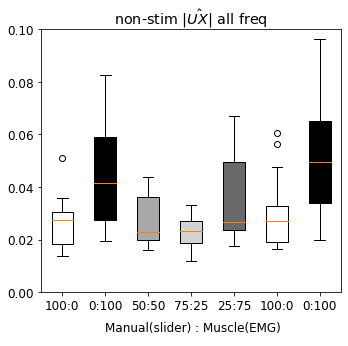

In [25]:
fig,axs = BOXPLOT(UXvalues,'non-stim $|\hat{UX}|$ all freq',ylimit0=0.1)
# fig.suptitle('non-stim UX below corssover')
plt.tight_layout()
plt.show()

In [26]:
w,pv,sig,flag = WilcoxonTest(UXvalues)
flag

['there is significant difference between condition 0 and condition 1, w = 1.0, pvalue = 0.0001220703125',
 'there is significant difference between condition 0 and condition 6, w = 1.0, pvalue = 0.0001220703125',
 'there is significant difference between condition 1 and condition 2, w = 7.0, pvalue = 0.00115966796875',
 'there is significant difference between condition 1 and condition 3, w = 3.0, pvalue = 0.00030517578125',
 'there is significant difference between condition 2 and condition 3, w = 17.0, pvalue = 0.012451171875',
 'there is significant difference between condition 2 and condition 6, w = 0.0, pvalue = 6.103515625e-05',
 'there is significant difference between condition 3 and condition 4, w = 10.0, pvalue = 0.00262451171875',
 'there is significant difference between condition 3 and condition 6, w = 0.0, pvalue = 6.103515625e-05',
 'there is significant difference between condition 4 and condition 6, w = 16.0, pvalue = 0.01025390625',
 'there is significant difference 

## all U below crossover

In [272]:
# U below corssover
Unorm = {}
for p in range(participants_num): 
    Unorm['subject'+str(p)] = {}
    for c in range(num_cond): 
        U_cross = np.mean(np.abs(np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:])[:,:11]), axis = 0) #average UX below corssover of all trials 
        Unorm['subject'+str(p)]['condition'+str(c)] = LA.norm(U_cross) 

Uvalues = [] # 7 conditions x (15participants * i/2 trials)
for c in range(num_cond):
    values_ = []
    for p in range(participants_num):
        values_.append(Unorm['subject'+str(p)]['condition'+str(c)]) #average of all trials of a participant of a condition
    Uvalues.append(values_) #each participant 

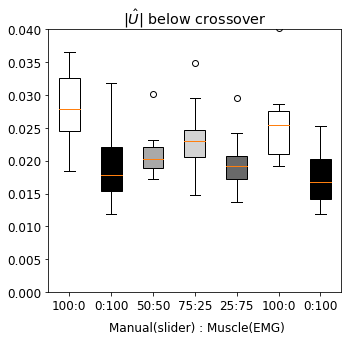

In [273]:
fig,axs = BOXPLOT(Uvalues,'$|\hat{U}|$ below crossover',ylimit0=0.04)
# fig.suptitle('non-stim UX below corssover')
plt.tight_layout()
plt.show()

## Costs (time doamin) |r-y|^2 + |u_FB|^2

In [274]:
last_trial = [8,8,10,10,10,2,2]

In [275]:
def COSTS(last_trial):
    """
    number of trials to look at of each condition: (ex: last 4)
    last_trial = [4,4,8,8,8,4,4]

    what freqs to look at over all 8 stim freqs: (ex: [1,2,3,4,5,6,7,8])
    first_freq = [0,1,2,3,4,5,6,7]
    """

    #(1) MSE time: for every trial for every participant (1 number for each trial)
    costs = {}
    for p in range(participants_num): # number of participants = 15
        costs['subject'+str(p)] = {}
        for c in range(num_cond):  # number of conditions  = 7
            r = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][-last_trial[c]:])
            y = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][-last_trial[c]:])
            u = np.asarray(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][-last_trial[c]:])
            ry = (r-y).astype(float)
            costs['subject'+str(p)]['condition'+str(c)] = (LA.norm(ry,axis=1))**2 + (LA.norm(u,axis=1))**2 #time domain error of each trial of each participant
            # costs['subject'+str(p)]['condition'+str(c)] = np.sum((r-y)**2,axis=1) + np.sum((u**2),axis=1) 

    costvalues = [] # 7 conditions x (15participants * i trials)
    for c in range(num_cond):
        values_ = []
        for p in range(participants_num):
            values_.append(np.mean(costs['subject'+str(p)]['condition'+str(c)])) #average TD error of all trials of a participant of a condition
        costvalues.append(values_)

    return costvalues #average MSE over all trials for every participant

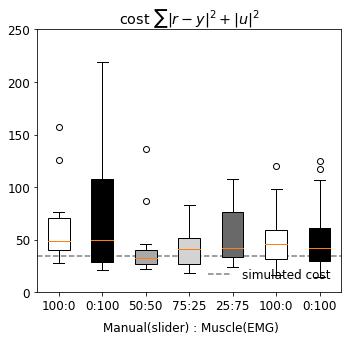

In [276]:
costvalues = COSTS(last_trial)
cost_sim = ((LA.norm(LQG_SIM['OE']['LQG_x'][:,0]) + LA.norm(LQG_SIM['OE']['LQG_u']) +
            LA.norm(LQG_SIM['EO']['LQG_x'][:,0]) + LA.norm(LQG_SIM['EO']['LQG_u'])) /2)**2  #average cost of OE & EO trials

fig,axs = BOXPLOT(costvalues,'cost $\sum |r-y|^2 + |u|^2$',ylimit0=250)
# fig.suptitle(plot_title)
hline = plt.axhline(y=cost_sim,color='grey',linestyle = '--',label='simulated cost')
from matplotlib.legend import Legend
legend1 = Legend(axs,[hline], ['simulated cost'],loc='lower right',frameon=False)
axs.add_artist(legend1)

plt.tight_layout()
plt.show()

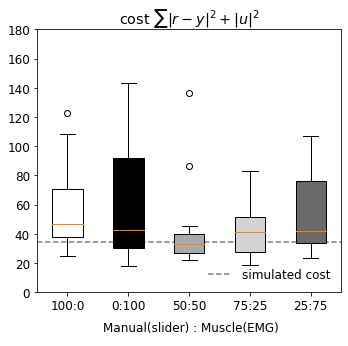

In [277]:
costvalues5 = [(np.array(costvalues[0])+np.array(costvalues[5]))/2, 
                (np.array(costvalues[1])+np.array(costvalues[6]))/2,
                costvalues[2],costvalues[3],costvalues[4]]

fig,axs = BOXPLOT5(costvalues5,'cost $\sum |r-y|^2 + |u|^2$',ylimit0=180)
# fig.suptitle(plot_title)
hline = plt.axhline(y=cost_sim,color='grey',linestyle = '--',label='simulated cost')
from matplotlib.legend import Legend
legend1 = Legend(axs,[hline], ['simulated cost'],loc='lower right',frameon=False)
axs.add_artist(legend1)

plt.tight_layout()
plt.show()

In [278]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [279]:
w, p = wilcoxon(costvalues[0],costvalues[2]) #**
w,p

(12.0, 0.0042724609375)

In [280]:
w, p = wilcoxon(costvalues[0],costvalues[3]) #***
w,p

(2.0, 0.00018310546875)

In [281]:
w, p = wilcoxon(costvalues[1],costvalues[2]) #*
w,p

(18.0, 0.01507568359375)

In [282]:
w, p = wilcoxon(costvalues[1],costvalues[3]) #*
w,p

(23.0, 0.03533935546875)

# non-stimulated user inputs 

## non-stim ux in freq domain

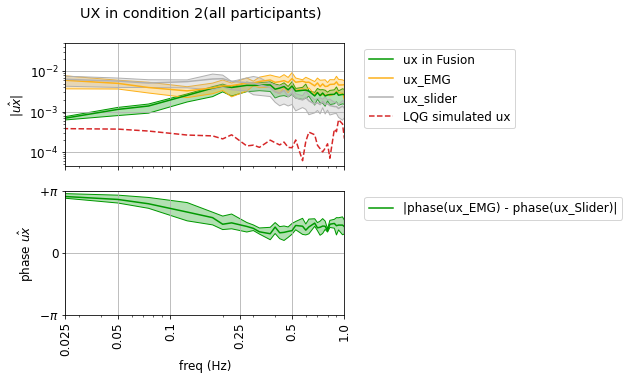

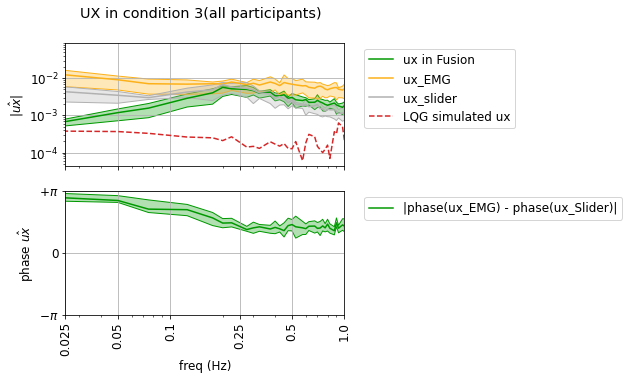

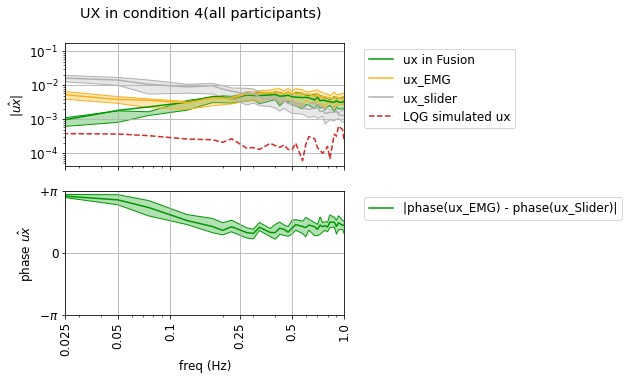

In [13]:
for c in [2,3,4]: #conditions
    # mag plots
    fig,axs = plt.subplots(2, 1,sharex=True,figsize=(5,5))
    xlim = (0.025, 1.0)
    xticks = np.array([.025,.05,.1,.25,.5,1.])
    ylim = (1e-4,1e-2)
    # yticks = [1e-2,0.1,1]
    # ytickslabels = [0.01,0.10,1.00]
    ylimphase = (-np.pi,np.pi)
    yticksphase = [-np.pi,0.,np.pi]
    yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']
    Colors = [colors['u'],colors['r'],colors['g']]
    FillColors = [ufill,rfill,gfill]
    Labels = ['ux in Fusion','ux_EMG','ux_slider'] #'ux in slider only','ux in EMG only'

    #mag
    ax = axs[0]

    UX_mean = []
    U0X_mean = []
    U1X_mean = []
    UX_sim = np.abs(LQG_SIM['EO']['LQG_U'][nonstimulated_index])
    # add_mean = []

    for p in range(participants_num):
        UX_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['UX'][-last_trial[c]:]) ,axis = 0) ) #avg UX of one participant
        U0X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) ,axis = 0) ) #avg UX of one participant
        U1X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:]) ,axis = 0) ) #avg UX of one participant
        # add_mean.append( np.mean( np.abs(0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) + 
        #                                  0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:])) ,axis = 0) ) #avg UX of one participant

    UX_mean_mean = np.mean( UX_mean, axis = 0) #avg UX of all participants
    U0X_mean_mean = np.mean( U0X_mean, axis = 0) #avg UX of all participants
    U1X_mean_mean = np.mean( U1X_mean, axis = 0) #avg UX of all participants

    UX_mean_25 = np.percentile(UX_mean, 25, axis=0)
    U0X_mean_25 = np.percentile(U0X_mean, 25, axis=0)
    U1X_mean_25 = np.percentile(U1X_mean, 25, axis=0)

    UX_mean_75 = np.percentile(UX_mean, 75, axis=0)
    U0X_mean_75 = np.percentile(U0X_mean, 75, axis=0)
    U1X_mean_75 = np.percentile(U1X_mean, 75, axis=0)

    ax.plot(xf[nonstimulated_index], UX_mean_mean , color=Colors[0], label=Labels[0])
    ax.plot(xf[nonstimulated_index], U0X_mean_mean , color=Colors[1], label=Labels[1])
    ax.plot(xf[nonstimulated_index], U1X_mean_mean , color=Colors[2], label=Labels[2])
    ax.plot(xf[nonstimulated_index], UX_sim , '--',color=colors['RED'], label='LQG simulated ux')


    #check if 0.5*(EMG+SLIDER) = overall u
    # add_mean_mean = np.mean( add_mean, axis = 0) #avg UX of all participants
    # ax.plot(xf[nonstimulated_index], add_mean_mean , color='black', label='addition')


    ax.fill_between(xf[nonstimulated_index], UX_mean_25, UX_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0])
    ax.fill_between(xf[nonstimulated_index], U0X_mean_25, U0X_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1])
    ax.fill_between(xf[nonstimulated_index], U1X_mean_25, U1X_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2])

    #plot difference of phases, i.e. complex(u_emg / u_slider)
    ax = axs[1]
    diff_phase_mean = []

    for p in range(participants_num):
        diff_phase = []
        for i in range(last_trial[c]):
            diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:][i] / 
                                DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:][i]) )
        diff_phase_mean.append( np.mean(np.abs(diff_phase), axis = 0) ) #avg phase diff of one participant

    diff_phase_mean_mean = np.mean( diff_phase_mean, axis = 0) #avg phase diff of all participants
    diff_phase_mean_25 = np.percentile(diff_phase_mean, 25, axis=0) 
    diff_phase_mean_75 = np.percentile(diff_phase_mean, 75, axis=0) 

    ax.plot(xf[nonstimulated_index], diff_phase_mean_mean , color=Colors[0], label='|phase(ux_EMG) - phase(ux_Slider)|')
    ax.fill_between(xf[nonstimulated_index], diff_phase_mean_25, diff_phase_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0])

    ax = axs[0]
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_yscale("log")
    # ax.set_ylim(ylim)
    # ax.set_yticks(yticks)
    # ax.set_yticklabels(ytickslabels)
    ax.grid('on',zorder=-1)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax.set_ylabel(r'$| \hat{ux} |$') 

    ax = axs[1]
    # ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase,**font)
    ax.grid('on',zorder=-1)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #   axs[0,0].title.set_text('3 conditions')

    
    axs[1].set_ylabel(r'phase $ \hat{ux} $')
    axs[1].set_xlabel('freq (Hz)')

    fig.suptitle('UX in condition '+str(c)+'(all participants)');
    plt.show()

## stim u in freq domain (EO)

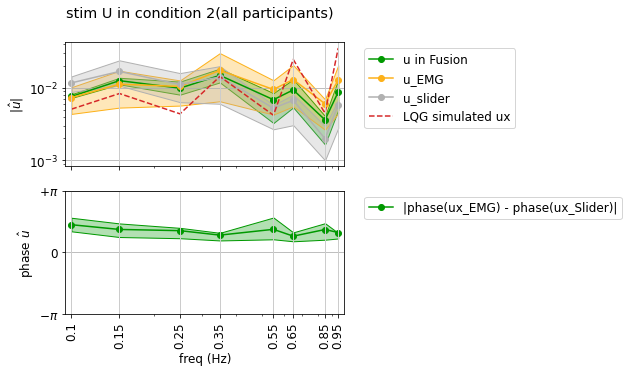

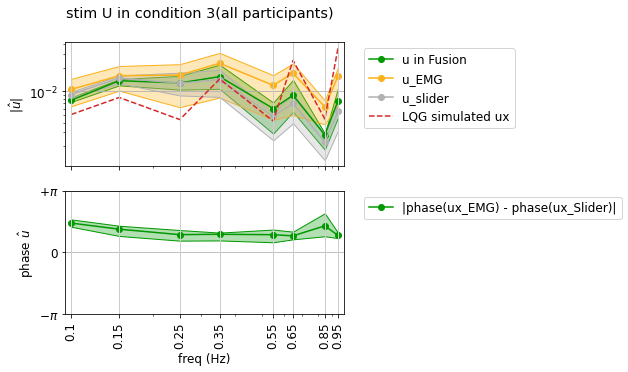

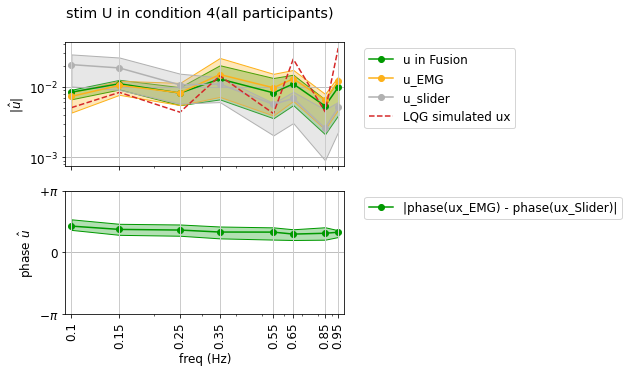

In [14]:
for c in [2,3,4]: #conditions
    # mag plots
    fig,axs = plt.subplots(2, 1,sharex=True,figsize=(5,5))
    xlim = (0.095, 1.0)
    xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95]) #prime*0.05
    ylim = (1e-3,1e-1)
    # yticks = [1e-2,0.1,1]
    # ytickslabels = [0.01,0.10,1.00]
    ylimphase = (-np.pi,np.pi)
    yticksphase = [-np.pi,0.,np.pi]
    yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']
    Colors = [colors['u'],colors['r'],colors['g']]
    FillColors = [ufill,rfill,gfill]
    Labels = ['u in Fusion','u_EMG','u_slider'] #'ux in slider only','ux in EMG only'

    #mag
    ax = axs[0]

    U_mean = []
    U0_mean = []
    U1_mean = []
    U_sim = np.abs(LQG_SIM['EO']['LQG_U'][stimulated_index])
    # add_mean = []

    for p in range(participants_num):
        U_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:][::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
        U0_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
        U1_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
        # add_mean.append( np.mean( np.abs(0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) + 
        #                                  0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:])) ,axis = 0) ) #avg UX of one participant

    U_mean_mean = np.mean( U_mean, axis = 0) #avg UX of all participants
    U0_mean_mean = np.mean( U0_mean, axis = 0) #avg UX of all participants
    U1_mean_mean = np.mean( U1_mean, axis = 0) #avg UX of all participants

    U_mean_25 = np.percentile(U_mean, 25, axis=0)
    U0_mean_25 = np.percentile(U0_mean, 25, axis=0)
    U1_mean_25 = np.percentile(U1_mean, 25, axis=0)

    U_mean_75 = np.percentile(U_mean, 75, axis=0)
    U0_mean_75 = np.percentile(U0_mean, 75, axis=0)
    U1_mean_75 = np.percentile(U1_mean, 75, axis=0)


    ax.plot(xf[stimulated_index], U_mean_mean, 'o-', color=Colors[0], label=Labels[0])
    ax.plot(xf[stimulated_index], U0_mean_mean,'o-', color=Colors[1], label=Labels[1])
    ax.plot(xf[stimulated_index], U1_mean_mean, 'o-', color=Colors[2], label=Labels[2])
    ax.plot(xf[stimulated_index], U_sim , '--',color=colors['RED'], label='LQG simulated ux')

    #check if 0.5*(EMG+SLIDER) = overall u
    # add_mean_mean = np.mean( add_mean, axis = 0) #avg UX of all participants
    # ax.plot(xf[nonstimulated_index], add_mean_mean , color='black', label='addition')

    ax.fill_between(xf[stimulated_index], U_mean_25, U_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0])
    ax.fill_between(xf[stimulated_index], U0_mean_25, U0_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1])
    ax.fill_between(xf[stimulated_index], U1_mean_25, U1_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2])

    # #phase
    # ax = axs[1]

    # U_mean = []
    # U0_mean = []
    # U1_mean = []
    # # add_mean = []

    # for p in range(participants_num):
    #     U_mean.append( np.mean( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
    #     U0_mean.append( np.mean( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
    #     U1_mean.append( np.mean( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
    #     # add_mean.append( np.mean( np.abs(0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) + 
    #     #                                  0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:])) ,axis = 0) ) #avg UX of one participant

    # U_mean_mean = np.mean( U_mean, axis = 0) #avg UX of all participants
    # U0_mean_mean = np.mean( U0_mean, axis = 0) #avg UX of all participants
    # U1_mean_mean = np.mean( U1_mean, axis = 0) #avg UX of all participants

    # U_mean_25 = np.percentile(U_mean, 25, axis=0)
    # U0_mean_25 = np.percentile(U0_mean, 25, axis=0)
    # U1_mean_25 = np.percentile(U1_mean, 25, axis=0)

    # U_mean_75 = np.percentile(U_mean, 75, axis=0)
    # U0_mean_75 = np.percentile(U0_mean, 75, axis=0)
    # U1_mean_75 = np.percentile(U1_mean, 75, axis=0)


    # ax.plot(xf[stimulated_index], U_mean_mean, 'o-', color=Colors[0], label=Labels[0])
    # ax.plot(xf[stimulated_index], U0_mean_mean,'o-', color=Colors[1], label=Labels[1])
    # ax.plot(xf[stimulated_index], U1_mean_mean, 'o-', color=Colors[2], label=Labels[2])

    # #check if 0.5*(EMG+SLIDER) = overall u
    # # add_mean_mean = np.mean( add_mean, axis = 0) #avg UX of all participants
    # # ax.plot(xf[nonstimulated_index], add_mean_mean , color='black', label='addition')

    # ax.fill_between(xf[stimulated_index], U_mean_25, U_mean_75,
    #                     facecolor=FillColors[0],edgecolor=Colors[0])
    # ax.fill_between(xf[stimulated_index], U0_mean_25, U0_mean_75,
    #                     facecolor=FillColors[1],edgecolor=Colors[1])
    # ax.fill_between(xf[stimulated_index], U1_mean_25, U1_mean_75,
    #                     facecolor=FillColors[2],edgecolor=Colors[2])
    
    #plot difference of phases, i.e. complex(u_emg / u_slider)
    ax = axs[1]
    diff_phase_mean = []

    for p in range(participants_num):
        diff_phase = []
        for i in range(last_trial[c]//2):
            diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][::2][i] / 
                                DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][::2][i])[stimulated_index] )
        diff_phase_mean.append( np.mean(np.abs(diff_phase), axis = 0) ) #avg phase diff of one participant

    diff_phase_mean_mean = np.mean( diff_phase_mean, axis = 0) #avg phase diff of all participants
    diff_phase_mean_25 = np.percentile(diff_phase_mean, 25, axis=0) 
    diff_phase_mean_75 = np.percentile(diff_phase_mean, 75, axis=0) 

    ax.plot(xf[stimulated_index], diff_phase_mean_mean ,'o-', color=Colors[0], label='|phase(ux_EMG) - phase(ux_Slider)|')
    ax.fill_between(xf[stimulated_index], diff_phase_mean_25, diff_phase_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0])


    ax = axs[0]
    for ii in prime: # prime multiples of a base frequency (1/20Hz)
        ax.axvline(x = ii*base_freq,linewidth=1, color='0.8')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_yscale("log")
    # ax.set_ylim(ylim)
    # ax.set_yticks(yticks)
    # ax.set_yticklabels(ytickslabels)
    ax.grid('on',zorder=-1)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    ax = axs[1]
    for ii in prime: # prime multiples of a base frequency (1/20Hz)
        ax.axvline(x = ii*base_freq,linewidth=1, color='0.8')
    # ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase,**font)
    ax.grid('on',zorder=-1)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #   axs[0,0].title.set_text('3 conditions')

    axs[0].set_ylabel(r'$| \hat{u} |$') 
    axs[1].set_ylabel(r'phase $ \hat{u} $')
    axs[1].set_xlabel('freq (Hz)')

    fig.suptitle('stim U in condition '+str(c)+'(all participants)')
    plt.show()

## stim u in freq domain (OE)

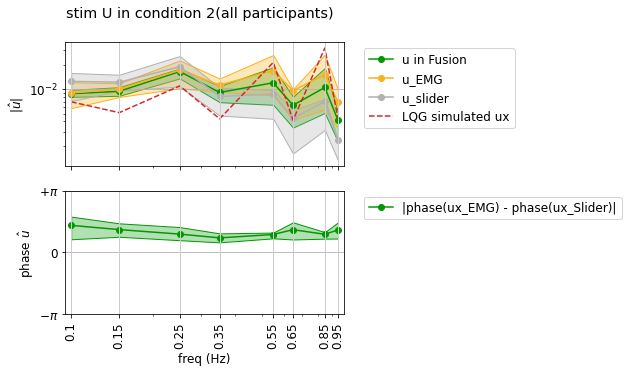

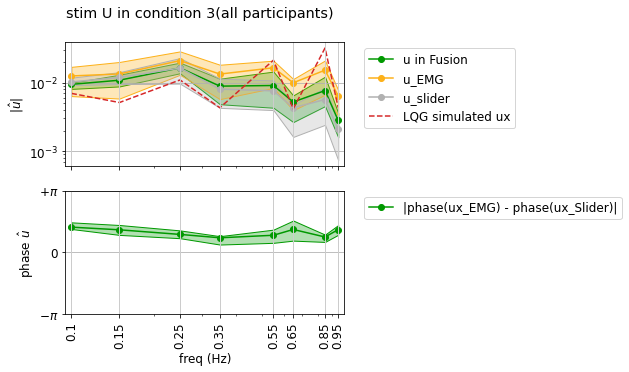

<ipython-input-15-ed9b0a598f17>:68: RuntimeWarning: divide by zero encountered in true_divide
  diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2][i] /
<ipython-input-15-ed9b0a598f17>:68: RuntimeWarning: invalid value encountered in true_divide
  diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2][i] /


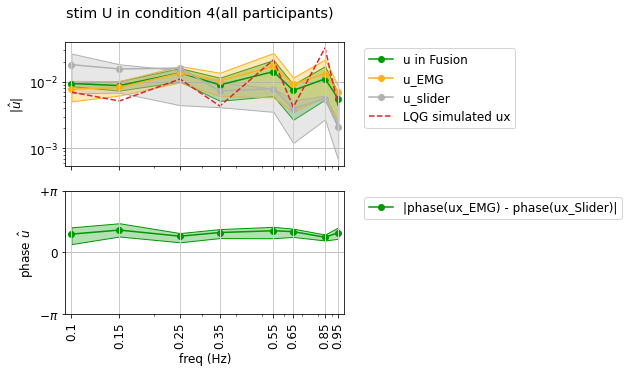

In [15]:
for c in [2,3,4]: #conditions
    # mag plots
    fig,axs = plt.subplots(2, 1,sharex=True,figsize=(5,5))
    xlim = (0.095, 1.0)
    xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95]) #prime*0.05
    ylim = (1e-3,1e-1)
    # yticks = [1e-2,0.1,1]
    # ytickslabels = [0.01,0.10,1.00]
    ylimphase = (-np.pi,np.pi)
    yticksphase = [-np.pi,0.,np.pi]
    yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']
    Colors = [colors['u'],colors['r'],colors['g']]
    FillColors = [ufill,rfill,gfill]
    Labels = ['u in Fusion','u_EMG','u_slider'] #'ux in slider only','ux in EMG only'

    #mag
    ax = axs[0]

    U_mean = []
    U0_mean = []
    U1_mean = []
    U_sim = np.abs(LQG_SIM['OE']['LQG_U'][stimulated_index])
    # add_mean = []

    for p in range(participants_num):
        U_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:][1::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
        U0_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
        U1_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][1::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
        # add_mean.append( np.mean( np.abs(0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) + 
        #                                  0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:])) ,axis = 0) ) #avg UX of one participant

    U_mean_mean = np.mean( U_mean, axis = 0) #avg UX of all participants
    U0_mean_mean = np.mean( U0_mean, axis = 0) #avg UX of all participants
    U1_mean_mean = np.mean( U1_mean, axis = 0) #avg UX of all participants

    U_mean_25 = np.percentile(U_mean, 25, axis=0)
    U0_mean_25 = np.percentile(U0_mean, 25, axis=0)
    U1_mean_25 = np.percentile(U1_mean, 25, axis=0)

    U_mean_75 = np.percentile(U_mean, 75, axis=0)
    U0_mean_75 = np.percentile(U0_mean, 75, axis=0)
    U1_mean_75 = np.percentile(U1_mean, 75, axis=0)


    ax.plot(xf[stimulated_index], U_mean_mean, 'o-', color=Colors[0], label=Labels[0])
    ax.plot(xf[stimulated_index], U0_mean_mean,'o-', color=Colors[1], label=Labels[1])
    ax.plot(xf[stimulated_index], U1_mean_mean, 'o-', color=Colors[2], label=Labels[2])
    ax.plot(xf[stimulated_index], U_sim , '--',color=colors['RED'], label='LQG simulated ux')

    #check if 0.5*(EMG+SLIDER) = overall u
    # add_mean_mean = np.mean( add_mean, axis = 0) #avg UX of all participants
    # ax.plot(xf[nonstimulated_index], add_mean_mean , color='black', label='addition')

    ax.fill_between(xf[stimulated_index], U_mean_25, U_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0])
    ax.fill_between(xf[stimulated_index], U0_mean_25, U0_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1])
    ax.fill_between(xf[stimulated_index], U1_mean_25, U1_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2])
    
    #plot difference of phases, i.e. complex(u_emg / u_slider)
    ax = axs[1]
    diff_phase_mean = []

    for p in range(participants_num):
        diff_phase = []
        for i in range(last_trial[c]//2):
            diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2][i] / 
                                DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][1::2][i])[stimulated_index] )
        diff_phase_mean.append( np.mean(np.abs(diff_phase), axis = 0) ) #avg phase diff of one participant

    diff_phase_mean_mean = np.mean( diff_phase_mean, axis = 0) #avg phase diff of all participants
    diff_phase_mean_25 = np.percentile(diff_phase_mean, 25, axis=0) 
    diff_phase_mean_75 = np.percentile(diff_phase_mean, 75, axis=0) 

    ax.plot(xf[stimulated_index], diff_phase_mean_mean ,'o-', color=Colors[0], label='|phase(ux_EMG) - phase(ux_Slider)|')
    ax.fill_between(xf[stimulated_index], diff_phase_mean_25, diff_phase_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0])


    ax = axs[0]
    for ii in prime: # prime multiples of a base frequency (1/20Hz)
        ax.axvline(x = ii*base_freq,linewidth=1, color='0.8')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_yscale("log")
    # ax.set_ylim(ylim)
    # ax.set_yticks(yticks)
    # ax.set_yticklabels(ytickslabels)
    ax.grid('on',zorder=-1)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    ax = axs[1]
    for ii in prime: # prime multiples of a base frequency (1/20Hz)
        ax.axvline(x = ii*base_freq,linewidth=1, color='0.8')
    # ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase,**font)
    ax.grid('on',zorder=-1)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #   axs[0,0].title.set_text('3 conditions')

    axs[0].set_ylabel(r'$| \hat{u} |$') 
    axs[1].set_ylabel(r'phase $ \hat{u} $')
    axs[1].set_xlabel('freq (Hz)')

    fig.suptitle('stim U in condition '+str(c)+'(all participants)');
    plt.show()

## replot - for ux and stim u

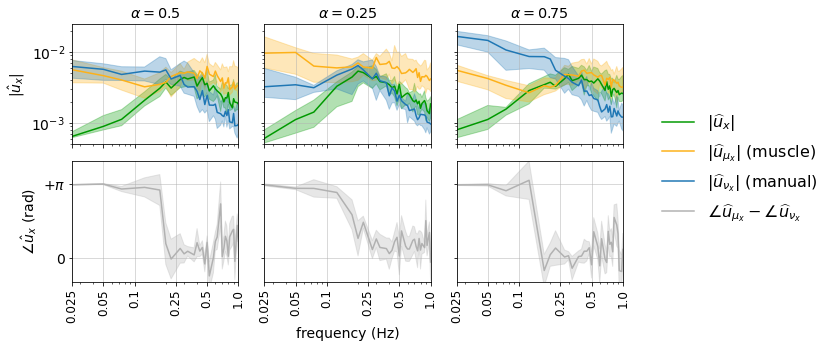

In [20]:
#mask for index of freq that are less than 1Hz
def lessthanone(x): return x <= 1.0
indexone = [idx for idx, element in enumerate(xf) if lessthanone(element)]
unwanted_index = {4, 6, 10, 14, 22, 26, 34, 38}
nonstimulated_index = [i for i in indexone if i not in unwanted_index]

#replot for presentations
fig,axs = plt.subplots(2, 3, sharex = 'col', sharey = 'row',figsize=(9,5))
j = 0
for c in [2,3,4]: #conditions
    # mag plots
    xlim = (0.025, 1.0)
    xticks = np.array([.025,.05,.1,.25,.5,1.])
    ylim = (0.5*1e-3,0.25*1e-1)
    yticks = [1e-2,1e-3]
    ytickslabels = [r'$10^{-2}$',r'$10^{-3}$']
    ylimphase = (-1,np.pi+1)
    yticksphase = [0.,np.pi]
    yticklabelsphase = [r'0',r'$+\pi$']
    Colors = [colors['u'],colors['r'],colors['BLUE']]
    FillColors = [ufill,rfill,bfill,gfill]
    Labels = [r'$|\widehat{u}_{x}|$',r'$|\widehat{u}_{\mu_{x}}|$ (muscle)',r'$|\widehat{u}_{\nu_{x}}|$ (manual)'] #'ux in slider only','ux in EMG only'

    #mag
    ax = axs[0,j]
    UX_mean = []
    U0X_mean = []
    U1X_mean = []
    UX_sim = np.abs(LQG_SIM['EO']['LQG_U'][nonstimulated_index])
    # add_mean = []

    for p in range(participants_num):
        UX_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['UX'][-last_trial[c]:]) ,axis = 0) ) #avg UX of one participant
        U0X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) ,axis = 0) ) #avg UX of one participant
        U1X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:]) ,axis = 0) ) #avg UX of one participant
        # add_mean.append( np.mean( np.abs(0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) + 
        #                                  0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:])) ,axis = 0) ) #avg UX of one participant

    # UX_mean_mean = np.mean( UX_mean, axis = 0) #avg UX of all participants
    # U0X_mean_mean = np.mean( U0X_mean, axis = 0) #avg UX of all participants
    # U1X_mean_mean = np.mean( U1X_mean, axis = 0) #avg UX of all participants
    UX_mean_mean = np.percentile(UX_mean, 50, axis=0)
    U0X_mean_mean = np.percentile(U0X_mean, 50, axis=0)
    U1X_mean_mean = np.percentile(U1X_mean, 50, axis=0)

    UX_mean_25 = np.percentile(UX_mean, 25, axis=0)
    U0X_mean_25 = np.percentile(U0X_mean, 25, axis=0)
    U1X_mean_25 = np.percentile(U1X_mean, 25, axis=0)

    UX_mean_75 = np.percentile(UX_mean, 75, axis=0)
    U0X_mean_75 = np.percentile(U0X_mean, 75, axis=0)
    U1X_mean_75 = np.percentile(U1X_mean, 75, axis=0)

    ax.plot(xf[nonstimulated_index], UX_mean_mean , color=Colors[0])
    ax.plot(xf[nonstimulated_index], U0X_mean_mean , color=Colors[1])
    ax.plot(xf[nonstimulated_index], U1X_mean_mean , color=Colors[2])

    ax.fill_between(xf[nonstimulated_index], UX_mean_25, UX_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0],alpha = 0.3)
    ax.fill_between(xf[nonstimulated_index], U0X_mean_25, U0X_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1],alpha = 0.3)
    ax.fill_between(xf[nonstimulated_index], U1X_mean_25, U1X_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2],alpha = 0.3)

    #plot difference of phases, i.e. complex(u_emg / u_slider)
    ax = axs[1,j]
    diff_phase_mean = []

    for p in range(participants_num):
        diff_phase = []
        for i in range(last_trial[c]):
            diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:][i] / 
                                DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:][i]) )                    
        # diff_phase_mean.append( np.mean(np.abs(diff_phase), axis = 0) ) #avg phase diff of one participant
        diff_phase_mean.append( np.angle( np.mean(np.exp(1j*np.asarray(diff_phase)), axis=0) ) )
        #circular stats

    # diff_phase_mean_mean = np.mean( diff_phase_mean, axis = 0) #avg phase diff of all participants
    # diff_phase_mean_mean = np.mean(np.exp(1j*diff_phase_mean), axis=0)
    # diff_phase_mean_25 = np.percentile(diff_phase_mean, 25, axis=0) 
    # diff_phase_mean_75 = np.percentile(diff_phase_mean, 75, axis=0) 
    z = np.mean(np.exp(1j*(np.asarray(diff_phase_mean)-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1-np.abs(z)

    ax.plot(xf[nonstimulated_index], mean , color=colors['g'],alpha = 1)
    # ax.fill_between(xf[nonstimulated_index], diff_phase_mean_25, diff_phase_mean_75,
    #                     facecolor=FillColors[3],edgecolor=colors['BLUE'],alpha = 0.2)
    ax.fill_between(xf[nonstimulated_index], mean+disp,mean-disp,
                        facecolor=FillColors[3],edgecolor=colors['g'],alpha = 0.3)

    ax = axs[0,j]
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yscale("log")
    ax.grid('on',zorder=-1,alpha = 0.6)
    
    ax = axs[1,j]
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.grid('on',zorder=-1,alpha = 0.6)

    j+=1
ax = axs[0,0]
ax.set_yticks(yticks)
ax.set_yticklabels(ytickslabels,fontsize = 14)
ax.plot([],[],color=Colors[0], label=Labels[0])
ax.plot([],[],color=Colors[1], label=Labels[1])
ax.plot([],[],color=Colors[2], label=Labels[2])
ax = axs[1,0]
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase,fontsize = 14)
ax.plot([],[],color=colors['g'], label=r'$\angle{\widehat{u}_{\mu_{x}}} - \angle{\widehat{u}_{\nu_{x}}}$')
axs[0,0].title.set_text(r'$\alpha = 0.5$')
axs[0,1].title.set_text(r'$\alpha = 0.25$')
axs[0,2].title.set_text(r'$\alpha = 0.75$')
axs[1,1].set_xlabel('frequency (Hz)',fontsize = 14)
axs[0,0].set_ylabel(r'$|\hat{u}_{x}|$',fontsize = 14) 
axs[1,0].set_ylabel(r'$\angle{\hat{u}_{x}}$ (rad)',fontsize = 14)

fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',frameon=False,fontsize = 16)
# axs[1,2].legend(bbox_to_anchor=(-0.3, -0.6), loc='center left',frameon=False,fontsize = 14)
# fig.suptitle('Non in condition '+str(c)+'(all participants)')
axs[0,1].get_shared_x_axes().join(axs[0,0], axs[0,1])
plt.tight_layout()
plt.show()

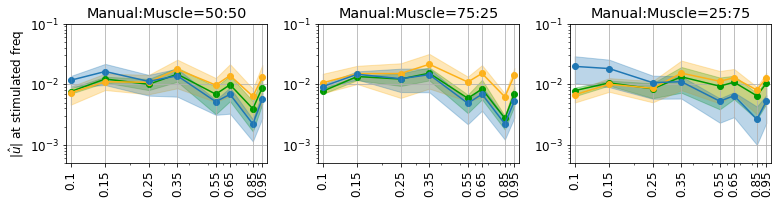

In [287]:
fig,axs = plt.subplots(1, 3,sharex=True,figsize=(11,3))

j=0
Colors = [colors['u'],colors['r'],colors['BLUE']]
for c in [2,3,4]: #conditions
    xlim = (0.095, 1.0)
    xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95]) #prime*0.05
    ylim = (0.5*1e-3,1e-1)
    for ii in prime: # prime multiples of a base frequency (1/20Hz)
        ax.axvline(x = ii*base_freq,linewidth=1, color='0.8',alpha = 0.1)

    #mag
    ax = axs[j]
    U_mean = []
    U0_mean = []
    U1_mean = []
    U_sim = np.abs(LQG_SIM['OE']['LQG_U'][stimulated_index])

    for p in range(participants_num):
        U_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:][1::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
        U0_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant
        U1_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][1::2]) ,axis = 0)[stimulated_index] ) #avg UX of one participant

    U_mean_mean = np.mean( U_mean, axis = 0) #avg UX of all participants
    U0_mean_mean = np.mean( U0_mean, axis = 0) #avg UX of all participants
    U1_mean_mean = np.mean( U1_mean, axis = 0) #avg UX of all participants

    U_mean_25 = np.percentile(U_mean, 25, axis=0)
    U0_mean_25 = np.percentile(U0_mean, 25, axis=0)
    U1_mean_25 = np.percentile(U1_mean, 25, axis=0)

    U_mean_75 = np.percentile(U_mean, 75, axis=0)
    U0_mean_75 = np.percentile(U0_mean, 75, axis=0)
    U1_mean_75 = np.percentile(U1_mean, 75, axis=0)

    ax.plot(xf[stimulated_index], U_mean_mean, 'o-', color=Colors[0], label=Labels[0])
    ax.plot(xf[stimulated_index], U0_mean_mean,'o-', color=Colors[1], label=Labels[1])
    ax.plot(xf[stimulated_index], U1_mean_mean, 'o-', color=Colors[2], label=Labels[2])

    ax.fill_between(xf[stimulated_index], U_mean_25, U_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0],alpha = 0.3)
    ax.fill_between(xf[stimulated_index], U0_mean_25, U0_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1],alpha = 0.3)
    ax.fill_between(xf[stimulated_index], U1_mean_25, U1_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2],alpha = 0.3)

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_yscale("log")
    ax.grid('on',zorder=-1)

    j+=1

axs[0].title.set_text('Manual:Muscle=50:50')
axs[1].title.set_text('Manual:Muscle=75:25')
axs[2].title.set_text('Manual:Muscle=25:75')
axs[0].set_ylabel(r'$|\hat{u}|$ at stimulated freq') 
plt.tight_layout()
plt.show()

In [288]:
fig,axs = plt.subplots(1, 5,sharex=True,figsize=(20,3))

j=0
Colors = [colors['u'],colors['r'],colors['BLUE']]
FillColors = [ufill,rfill,bfill,gfill]
for c in [0,1,2,3,4]: #conditions
    xlim = (0.025, 1.0)
    xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95]) #prime*0.05
    # ylim = (0.5*1e-3,1e-1)
    ylim = (0.5*1e-3,0.25*1e-1)

    #mag
    ax = axs[j]
    U_mean = []
    U0_mean = []
    U1_mean = []
    U_sim = np.abs(LQG_SIM['OE']['LQG_U'][stimulated_index])

    for p in range(participants_num):
        U_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:][1::2]) ,axis = 0)[:N//2] ) #avg UX of one participant
        U0_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2]) ,axis = 0)[:N//2] ) #avg UX of one participant
        U1_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][1::2]) ,axis = 0)[:N//2] ) #avg UX of one participant

    # U_mean_mean = np.mean( U_mean, axis = 0) #avg UX of all participants
    # U0_mean_mean = np.mean( U0_mean, axis = 0) #avg UX of all participants
    # U1_mean_mean = np.mean( U1_mean, axis = 0) #avg UX of all participants
    U_mean_50 = np.percentile(U_mean, 50, axis=0)
    U0_mean_50 = np.percentile(U0_mean, 50, axis=0)
    U1_mean_50 = np.percentile(U1_mean, 50, axis=0)

    U_mean_25 = np.percentile(U_mean, 25, axis=0)
    U0_mean_25 = np.percentile(U0_mean, 25, axis=0)
    U1_mean_25 = np.percentile(U1_mean, 25, axis=0)

    U_mean_75 = np.percentile(U_mean, 75, axis=0)
    U0_mean_75 = np.percentile(U0_mean, 75, axis=0)
    U1_mean_75 = np.percentile(U1_mean, 75, axis=0)

    
    if c != 0:
        ax.plot(xf, U0_mean_50, color=Colors[1], label=Labels[1])
        ax.fill_between(xf, U0_mean_25, U0_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1],alpha = 0.3)
    if c != 1:
        ax.plot(xf, U1_mean_50, color=Colors[2], label=Labels[2])
        ax.fill_between(xf, U1_mean_25, U1_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2],alpha = 0.3)
    
    if c > 1:
        ax.plot(xf, U_mean_50,  color=Colors[0], label=Labels[0])
        ax.fill_between(xf, U_mean_25, U_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0],alpha = 0.3)

    for ii in prime: # prime multiples of a base frequency (1/20Hz)
        ax.axvline(x = ii*base_freq,linewidth=1, color='0.8',alpha = 0.1)
    # ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_yscale("log")
    ax.grid('on',zorder=-1)

    j+=1

axs[0].title.set_text('Manual:Muscle=100:0')
axs[1].title.set_text('Manual:Muscle=0:100')
axs[2].title.set_text('Manual:Muscle=50:50')
axs[3].title.set_text('Manual:Muscle=75:25')
axs[4].title.set_text('Manual:Muscle=25:75')
axs[0].set_ylabel(r'$|\hat{u}|$ at all freq') 
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

<ipython-input-208-0d531b2556a6>:64: RuntimeWarning: divide by zero encountered in true_divide
  diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2][i] /
<ipython-input-208-0d531b2556a6>:64: RuntimeWarning: invalid value encountered in true_divide
  diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2][i] /
<ipython-input-208-0d531b2556a6>:64: RuntimeWarning: divide by zero encountered in true_divide
  diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2][i] /
<ipython-input-208-0d531b2556a6>:64: RuntimeWarning: invalid value encountered in true_divide
  diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2][i] /
<ipython-input-208-0d531b2556a6>:112: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations

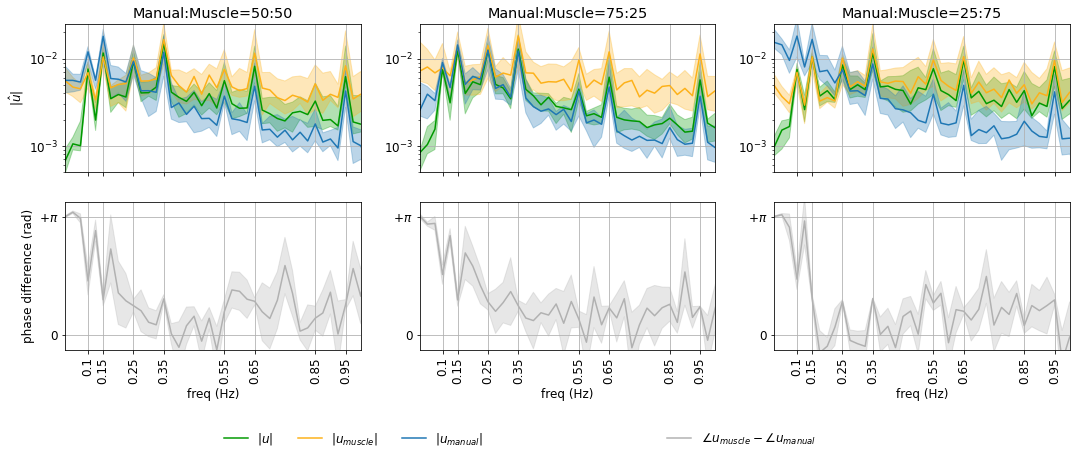

In [ ]:
#replot for presentations
fig,axs = plt.subplots(2, 3,sharex=True,figsize=(18,6))
j = 0
for c in [2,3,4]: #conditions
    # mag plots
    xlim = (0.025, 1.0)
    # xticks = np.array([.025,.05,.1,.25,.5,1.])
    xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95]) #prime*0.05
    ylim = (0.5*1e-3,0.25*1e-1)
    # yticks = [1e-2,0.1,1]
    # ytickslabels = [0.01,0.10,1.00]
    ylimphase = (-0.4,np.pi+0.4)
    yticksphase = [0.,np.pi]
    yticklabelsphase = [r'0',r'$+\pi$']
    Colors = [colors['u'],colors['r'],colors['BLUE']]
    FillColors = [ufill,rfill,bfill,gfill]
    Labels = [r'$|u|$',r'$|u_{muscle}|$',r'$|u_{manual}|$'] #'ux in slider only','ux in EMG only'

    #mag
    ax = axs[0,j]
    UX_mean = []
    U0X_mean = []
    U1X_mean = []
    # UX_sim = np.abs(LQG_SIM['EO']['LQG_U'][nonstimulated_index])
    # add_mean = []

    for p in range(participants_num):
        UX_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][-last_trial[c]:][1::2]) ,axis = 0)[:N//2] ) #avg UX of one participant
        U0X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2]) ,axis = 0)[:N//2] ) #avg UX of one participant
        U1X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][1::2]) ,axis = 0)[:N//2] ) #avg UX of one participant
        # add_mean.append( np.mean( np.abs(0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) + 
        #                                  0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:])) ,axis = 0) ) #avg UX of one participant

    UX_mean_50 = np.percentile(UX_mean, 50, axis=0) #avg UX of all participants
    U0X_mean_50 = np.percentile(U0X_mean, 50, axis=0) #avg UX of all participants
    U1X_mean_50 = np.percentile(U1X_mean, 50, axis=0) #avg UX of all participants

    UX_mean_25 = np.percentile(UX_mean, 25, axis=0)
    U0X_mean_25 = np.percentile(U0X_mean, 25, axis=0)
    U1X_mean_25 = np.percentile(U1X_mean, 25, axis=0)

    UX_mean_75 = np.percentile(UX_mean, 75, axis=0)
    U0X_mean_75 = np.percentile(U0X_mean, 75, axis=0)
    U1X_mean_75 = np.percentile(U1X_mean, 75, axis=0)

    ax.plot(xf, UX_mean_50 , color=Colors[0], label=Labels[0])
    ax.plot(xf, U0X_mean_50 , color=Colors[1], label=Labels[1])
    ax.plot(xf, U1X_mean_50 , color=Colors[2], label=Labels[2])

    ax.fill_between(xf, UX_mean_25, UX_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0],alpha = 0.3)
    ax.fill_between(xf, U0X_mean_25, U0X_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1],alpha = 0.3)
    ax.fill_between(xf, U1X_mean_25, U1X_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2],alpha = 0.3)

    #plot difference of phases, i.e. complex(u_emg / u_slider)
    ax = axs[1,j]
    diff_phase_mean = []

    for p in range(participants_num):
        diff_phase = []
        for i in range(last_trial[c]//2):
            diff_phase.append( np.angle(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][-last_trial[c]:][1::2][i] / 
                                DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][-last_trial[c]:][1::2][i])[:N//2] )                    
        # diff_phase_mean.append( np.mean(np.abs(diff_phase), axis = 0) ) #avg phase diff of one participant
        diff_phase_mean.append( np.angle( np.mean(np.exp(1j*np.asarray(diff_phase)), axis=0) ) )
        #circular stats

    # diff_phase_mean_mean = np.mean( diff_phase_mean, axis = 0) #avg phase diff of all participants
    # diff_phase_mean_mean = np.mean(np.exp(1j*diff_phase_mean), axis=0)
    # diff_phase_mean_25 = np.percentile(diff_phase_mean, 25, axis=0) 
    # diff_phase_mean_75 = np.percentile(diff_phase_mean, 75, axis=0) 
    z = np.mean(np.exp(1j*(np.asarray(diff_phase_mean)-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1-np.abs(z)

    ax.plot(xf, mean , color=colors['g'], label=r'$\angle{u_{muscle}} - \angle{u_{manual}}$')
    # ax.fill_between(xf[nonstimulated_index], diff_phase_mean_25, diff_phase_mean_75,
    #                     facecolor=FillColors[3],edgecolor=colors['BLUE'],alpha = 0.2)
    ax.fill_between(xf, mean+disp,mean-disp,
                        facecolor=FillColors[3],edgecolor=colors['g'],alpha = 0.3)

    ax = axs[0,j]
    # ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yscale("log")
    ax.grid('on',zorder=-1)
    
    ax = axs[1,j]
    # ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase,**font)
    ax.grid('on',zorder=-1)
    axs[1,j].set_xlabel('freq (Hz)')

    j+=1
    
axs[0,0].title.set_text('Manual:Muscle=50:50')
axs[0,1].title.set_text('Manual:Muscle=75:25')
axs[0,2].title.set_text('Manual:Muscle=25:75')
axs[0,0].set_ylabel(r'$|\hat{u}|$') 
axs[1,0].set_ylabel(r'phase difference (rad)')
axs[0,0].legend(bbox_to_anchor=(0.5, -1.8), loc='center left',ncol=4,frameon=False)
axs[1,2].legend(bbox_to_anchor=(-0.4, -0.6), loc='center left',frameon=False)
# fig.suptitle('Non in condition '+str(c)+'(all participants)')
plt.tight_layout()
plt.show()

## comapre 1-modality and 2-modality ux

<ipython-input-143-e959457e77b7>:78: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


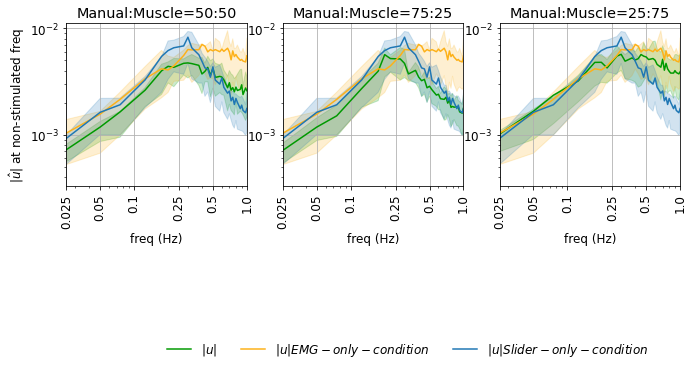

In [ ]:
#replot for presentations
fig,axs = plt.subplots(1, 3,sharex=True,figsize=(11,3))
j = 0
for c in [2,3,4]: #conditions
    # mag plots
    xlim = (0.025, 1.0)
    xticks = np.array([.025,.05,.1,.25,.5,1.])
    ylim = (0.5*1e-3,0.25*1e-1)
    # yticks = [1e-2,0.1,1]
    # ytickslabels = [0.01,0.10,1.00]
    Colors = [colors['u'],colors['r'],colors['BLUE']]
    FillColors = [ufill,rfill,bfill,gfill]
    Labels = [r'$|u|$',r'$|u| EMG-only-condition$',r'$|u| Slider-only-condition$'] #'ux in slider only','ux in EMG only'

    #mag
    ax = axs[j]
    UX_mean = []
    U0X_mean = []
    U1X_mean = []
    UX_sim = np.abs(LQG_SIM['EO']['LQG_U'][nonstimulated_index])
    # add_mean = []

    for p in range(participants_num):
        UX_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['UX'][-last_trial[c]:]) ,axis = 0) ) #fusion condition
        U0X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(1)]['UX'][-last_trial[1]:]) ,axis = 0) ) #1-modality - emg
        U0X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(6)]['UX'][-last_trial[6]:]) ,axis = 0) ) #1-modality - emg2

        U1X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(0)]['UX'][-last_trial[0]:]) ,axis = 0) ) #1-modality - slider
        U1X_mean.append( np.mean( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(5)]['UX'][-last_trial[5]:]) ,axis = 0) ) #1-modality - slider2
        # add_mean.append( np.mean( np.abs(0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0X'][-last_trial[c]:]) + 
        #                                  0.5*np.asarray(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1X'][-last_trial[c]:])) ,axis = 0) ) #avg UX of one participant

    UX_mean_mean = np.mean( UX_mean, axis = 0) #avg UX of all participants
    U0X_mean_mean = np.mean( U0X_mean, axis = 0) #avg UX of all participants
    U1X_mean_mean = np.mean( U1X_mean, axis = 0) #avg UX of all participants

    UX_mean_25 = np.percentile(UX_mean, 25, axis=0)
    U0X_mean_25 = np.percentile(U0X_mean, 25, axis=0)
    U1X_mean_25 = np.percentile(U1X_mean, 25, axis=0)

    UX_mean_75 = np.percentile(UX_mean, 75, axis=0)
    U0X_mean_75 = np.percentile(U0X_mean, 75, axis=0)
    U1X_mean_75 = np.percentile(U1X_mean, 75, axis=0)

    ax.plot(xf[nonstimulated_index], UX_mean_mean , color=Colors[0], label=Labels[0])
    ax.plot(xf[nonstimulated_index], U0X_mean_mean , color=Colors[1], label=Labels[1])
    ax.plot(xf[nonstimulated_index], U1X_mean_mean , color=Colors[2], label=Labels[2])

    ax.fill_between(xf[nonstimulated_index], UX_mean_25, UX_mean_75,
                        facecolor=FillColors[0],edgecolor=Colors[0],alpha = 0.2)
    ax.fill_between(xf[nonstimulated_index], U0X_mean_25, U0X_mean_75,
                        facecolor=FillColors[1],edgecolor=Colors[1],alpha = 0.2)
    ax.fill_between(xf[nonstimulated_index], U1X_mean_25, U1X_mean_75,
                        facecolor=FillColors[2],edgecolor=Colors[2],alpha = 0.2)

    ax = axs[j]
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    # ax.set_ylim(ylim)
    ax.set_yscale("log")
    ax.grid('on',zorder=-1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    # ax.set_ylim(ylimphase)
    # ax.set_yticks(yticksphase)
    # ax.set_yticklabels(yticklabelsphase,**font)
    ax.grid('on',zorder=-1)
    ax.set_xlabel('freq (Hz)')
    
    j+=1
    
axs[0].title.set_text('Manual:Muscle=50:50')
axs[1].title.set_text('Manual:Muscle=75:25')
axs[2].title.set_text('Manual:Muscle=25:75')
axs[0].set_ylabel(r'$|\hat{u}|$ at non-stimulated freq') 
axs[0].legend(bbox_to_anchor=(0.5, -1), loc='center left',ncol=4,frameon=False)
# fig.suptitle('Non in condition '+str(c)+'(all participants)')
plt.tight_layout()
plt.show()


## predict 25/75 with 50:50 condition

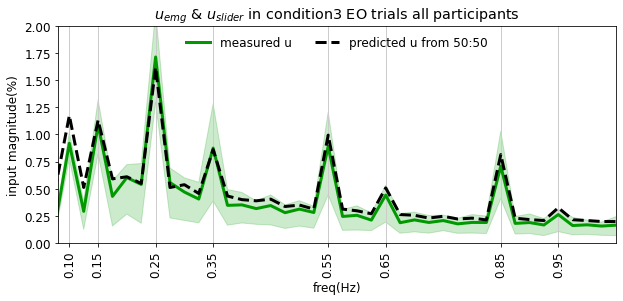

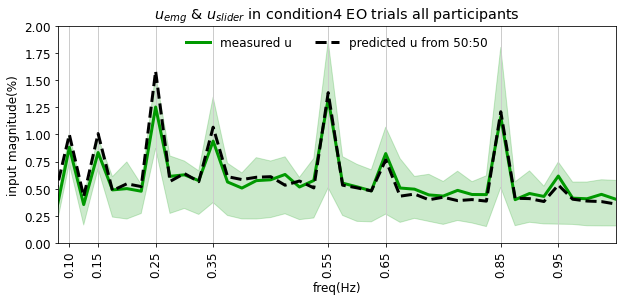

In [18]:
# rescale EMG & slider inputs in 50:50 and overlay on 25/75 plots
c = 2
in_all = []
in0_all = []
in1_all = []

for p in range(participants_num): #subject number
    for i in range(0,trialnum[2],2): #EO trials
        in_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput ) #measured
        in0_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i]/scaleInput ) #measured
        in1_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i]/scaleInput ) #measured

u0_measure = [np.abs(FFT((in0_all[i])*scaleInput,N)[:N//2]) for i in range(participants_num*(trialnum[c]//2))] #mag of FFT(uFB)
u0_mean = np.mean(u0_measure,axis =0)
u1_measure = [np.abs(FFT((in1_all[i])*scaleInput,N)[:N//2]) for i in range(participants_num*(trialnum[c]//2))] #mag of FFT(uFB)
u1_mean = np.mean(u1_measure,axis =0)

u_predict_25 = u0_mean*0.25 + u1_mean *0.75
u_predict_75 = u0_mean*0.75 + u1_mean *0.25

c = 3 #emg25%
in_all = []
in0_all = []
in1_all = []

for p in range(participants_num): #subject number
    for i in range(0,trialnum[2],2): #EO trials
        in_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput ) #measured
        in0_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i]/scaleInput ) #measured
        in1_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i]/scaleInput ) #measured
u_measure = [np.abs(FFT((in_all[i])*scaleInput,N)[:N//2]) for i in range(participants_num*(trialnum[c]//2))] #mag of FFT(uFB)
u_mean = np.mean(u_measure,axis =0)
u_75 = np.percentile(u_measure,75,axis =0)
u_25 = np.percentile(u_measure,25,axis =0)

plt.figure(figsize=(10, 4))
for ii in prime: # prime multiples of a base frequency (1/20Hz)
    plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

plt.plot(xf,u_mean*100, color=colors['u'],label='measured u',linewidth = 3)
plt.plot(xf,u_predict_25*100, '--',color='black',label='predicted u from 50:50',linewidth = 3)

# plt.plot(xf,u0_mean*100, color=colors['r'],label=r'measured $u_{emg}$',linewidth = 3)
# plt.plot(xf,u1_mean*100, color=colors['BLUE'],label=r'measured $u_{slider}$',linewidth = 3)

plt.fill_between(xf,u_25*100,u_75*100, facecolor=ufill,edgecolor=colors['u'],alpha=0.2)
plt.xlim((0.08,21*base_freq))
plt.ylim((0,2))

plt.xlabel('freq(Hz)')
plt.ylabel('input magnitude(%)')
plt.xticks(prime*0.05,rotation = 90)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend( loc='upper center', ncol=2, frameon=False)
plt.title(r'$u_{emg}$ & $u_{slider}$ in condition'+str(c)+' EO trials all participants')
plt.show()

c = 4 #emg75%
in_all = []
in0_all = []
in1_all = []

for p in range(participants_num): #subject number
    for i in range(0,trialnum[2],2): #EO trials
        in_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput ) #measured
        in0_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i]/scaleInput ) #measured
        in1_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i]/scaleInput ) #measured
u_measure = [np.abs(FFT((in_all[i])*scaleInput,N)[:N//2]) for i in range(participants_num*(trialnum[c]//2))] #mag of FFT(uFB)
u_mean = np.mean(u_measure,axis =0)
u_75 = np.percentile(u_measure,75,axis =0)
u_25 = np.percentile(u_measure,25,axis =0)

plt.figure(figsize=(10, 4))
for ii in prime: # prime multiples of a base frequency (1/20Hz)
    plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

plt.plot(xf,u_mean*100, color=colors['u'],label='measured u',linewidth = 3)
plt.plot(xf,u_predict_75*100, '--',color='black',label='predicted u from 50:50',linewidth = 3)

# plt.plot(xf,u0_mean*100, color=colors['r'],label=r'measured $u_{emg}$',linewidth = 3)
# plt.plot(xf,u1_mean*100, color=colors['BLUE'],label=r'measured $u_{slider}$',linewidth = 3)

plt.fill_between(xf,u_25*100,u_75*100, facecolor=ufill,edgecolor=colors['u'],alpha=0.2)
plt.xlim((0.08,21*base_freq))
plt.ylim((0,2))

plt.xlabel('freq(Hz)')
plt.ylabel('input magnitude(%)')
plt.xticks(prime*0.05,rotation = 90)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend( loc='upper center', ncol=2, frameon=False)
plt.title(r'$u_{emg}$ & $u_{slider}$ in condition'+str(c)+' EO trials all participants')
plt.show()

## DC gain of u_emg & u_slider

<>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-289-ae9c42fa2287>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if c is not 0:
<ipython-input-289-ae9c42fa2287>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if c is not 1:


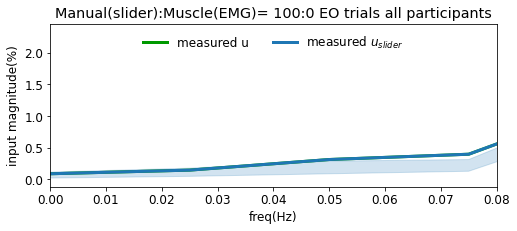

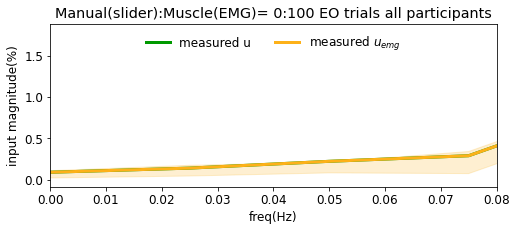

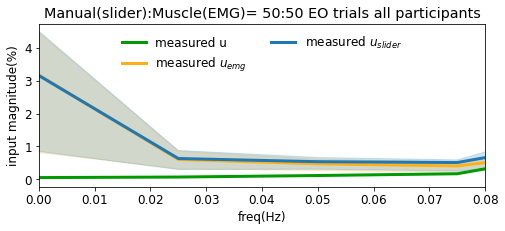

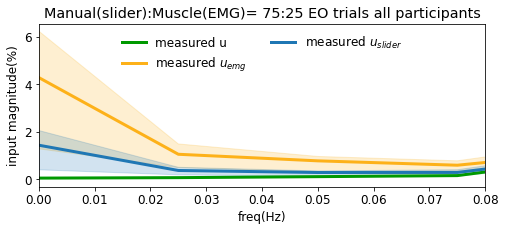

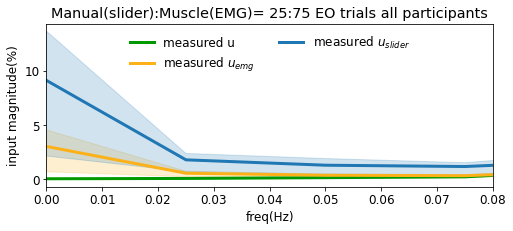

In [289]:
titles = ['100:0','0:100','50:50','75:25','25:75'] 

for c in [0,1,2,3,4]: #condition number
    in_all = []
    in0_all = []
    in1_all = []

    for p in range(participants_num): #subject number
        for i in range(0,trialnum[c],2): #EO trials
            in_all.append( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][i])[:N//2] ) #measured
            in0_all.append( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][i])[:N//2] ) #measured
            in1_all.append( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][i])[:N//2] ) #measured

    plt.figure(figsize=(8, 3))
    u_mean = np.mean(in_all,axis =0)
    u_75 = np.percentile(in_all,75,axis =0)
    u_25 = np.percentile(in_all,25,axis =0)

    u0_mean = np.mean(in0_all,axis =0)
    u0_75 = np.percentile(in0_all,75,axis =0)
    u0_25 = np.percentile(in0_all,25,axis =0)

    u1_mean = np.mean(in1_all,axis =0)
    u1_75 = np.percentile(in1_all,75,axis =0)
    u1_25 = np.percentile(in1_all,25,axis =0)
    
    plt.plot(xf,u_mean*100, color=colors['u'],label='measured u',linewidth = 3)
    if c is not 0:
        plt.plot(xf,u0_mean*100, color=colors['r'],label=r'measured $u_{emg}$',linewidth = 3)
        plt.fill_between(xf,u0_25*100,u0_75*100, facecolor=rfill,edgecolor=colors['r'],alpha=0.2)
    if c is not 1:
        plt.plot(xf,u1_mean*100, color=colors['BLUE'],label=r'measured $u_{slider}$',linewidth = 3)
        plt.fill_between(xf,u1_25*100,u1_75*100, facecolor=bfill,edgecolor=colors['BLUE'],alpha=0.2)

    plt.xlim((0,0.08))
    # plt.ylim((0,2))

    plt.xlabel('freq(Hz)')
    plt.ylabel('input magnitude(%)')
    # plt.xticks(prime*0.05,rotation = 90)
    # plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.legend( loc='upper center', ncol=2, frameon=False)
    plt.title('Manual(slider):Muscle(EMG)= '+titles[c]+' EO trials all participants')
    plt.show()

In [290]:
DC_u0 = []
DC_u1 = []
for c in [0,1,2,3,4]: #condition number
    in0_all = []
    in1_all = []

    for p in range(participants_num): #subject number
        for i in range(0,trialnum[c],2): #EO trials
            # in_all.append( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][i])[:N//2] ) #measured
            in0_all.append( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U0'][i])[:N//2] ) #measured
            in1_all.append( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U1'][i])[:N//2] ) #measured
    
    DC_u0.append( np.asarray(in0_all)[:,0]*100 )
    DC_u1.append( np.asarray(in1_all)[:,0]*100 )
# DC_u0[0] = 0
# DC_u1[1] = 0


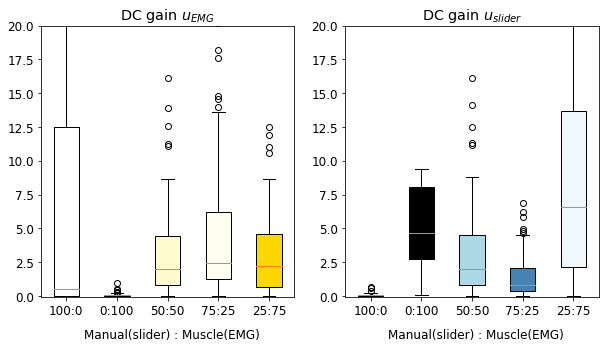

In [291]:
labels = ['100:0','0:100','50:50','75:25','25:75'] #slider : EMG

# boxcolors = ['darkgrey','lightgrey','dimgrey']
fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

# subplot 0
ax = axs[0]
boxcolors = ['white','black','lemonchiffon','ivory','gold']
bplot = ax.boxplot(DC_u0, widths = 0.5,patch_artist=True,labels=labels)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)

ax.title.set_text(r'DC gain $u_{EMG}$')
# ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
ax.set_ylim(-0.1,20)
    
ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

# subplot 1
ax = axs[1]
boxcolors = ['white','black','lightblue','steelblue','aliceblue']
bplot = ax.boxplot(DC_u1, widths = 0.5,patch_artist=True,labels=labels)
for patch, color in zip(bplot['boxes'], boxcolors):
    patch.set_facecolor(color)

ax.title.set_text(r'DC gain $u_{slider}$')
# ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
ax.set_ylim(-0.1,20)

ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)


## use biceps more in fusion?

In [457]:
# does user use their biceps more in fusion case and leads to positive DC offset of EMG data? 
# and use slider to oppose it?

#look at time domain u_EMG (seperate biceps & triceps)
u0_all = []
u_biceps = []
u_triceps = []
for c in [2,3,4]:
    u_biceps_trial_mean = []
    u_triceps_trial_mean = []    
    for p in range(participants_num):
        u_biceps_mean = [] 
        u_triceps_mean = []
        for i in range(trialnum[c]): 
            # u0_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i] )

            u_biceps_ = copy.copy(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i])
            u_biceps_[u_biceps_ < 0] = 0
            u_biceps_mean.append(np.mean(u_biceps_)) #mean of time domain u_emg_bicep of every trial

            u_triceps_ = copy.copy(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i])
            u_triceps_[u_triceps_ > 0] = 0
            u_triceps_mean.append(np.mean(-u_triceps_)) #mean of time domain u_emg_tricep of every trial
        u_biceps_trial_mean.append( np.mean(u_biceps_mean) ) #mean of trial of every participants
        u_triceps_trial_mean.append( np.mean(u_triceps_mean) )

    u_biceps.append( u_biceps_trial_mean )
    u_triceps.append( u_triceps_trial_mean )

# u_biceps_mean = np.mean(u_biceps,axis=0)
# u_triceps_mean = np.mean(u_triceps,axis=0)

In [458]:
len(u_biceps[0])

15

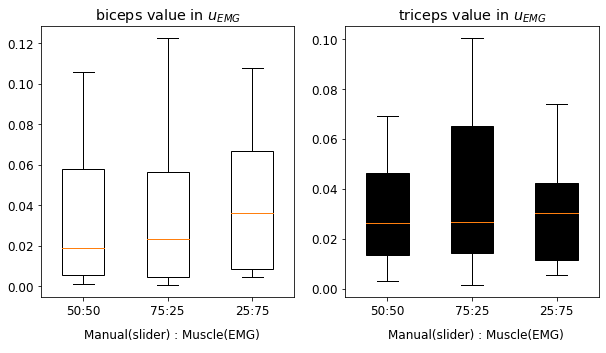

In [459]:
labels = ['50:50','75:25','25:75'] #slider : EMG

# boxcolors = ['darkgrey','lightgrey','dimgrey']
fig,axs = plt.subplots(1, 2,figsize=(10,5)) 

# subplot 0
ax = axs[0]
boxcolors = ['white','white','white']
bplot = ax.boxplot(u_biceps, widths = 0.5,patch_artist=True,labels=labels)
for patch, color in zip(bplot['boxes'], boxcolors): # fill with colors
    patch.set_facecolor(color)

ax.title.set_text(r'biceps value in $u_{EMG}$')
# ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
# ax.set_ylim(-0.1,20)
    
ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)

# subplot 1
ax = axs[1]
boxcolors = ['black','black','black']
bplot = ax.boxplot(u_triceps, widths = 0.5,patch_artist=True,labels=labels)
for patch, color in zip(bplot['boxes'], boxcolors):
    patch.set_facecolor(color)

ax.title.set_text(r'triceps value in $u_{EMG}$')
# ax.set_ylabel(r'$MSE_{time}$ = $\sum |r-y|^{2}$')
# ax.set_ylim(-0.1,20)

ax.plot([], [], ' ', label='Manual(slider) : Muscle(EMG)')
ax.legend(bbox_to_anchor=(0.45, -0.2), loc='lower center',frameon=False)


In [462]:
w, p = wilcoxon(u_biceps[2],u_triceps[2])
w,p

(54.0, 0.76153564453125)

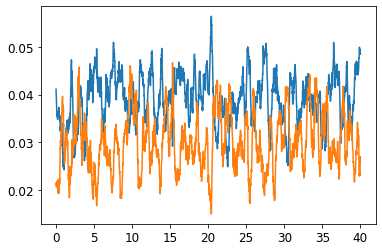

In [382]:
#look at time domain u_EMG (seperate biceps & triceps)
u0_all = []
u_biceps = []
u_triceps = []
for p in range(participants_num):
    for c in [4]:
        for i in range(trialnum[c]): 
            # u0_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i] )

            u_biceps_ = copy.copy(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i])
            u_biceps_[u_biceps_ < 0] = 0
            u_biceps.append(u_biceps_)

            u_triceps_ = copy.copy(DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i])
            u_triceps_[u_triceps_ > 0] = 0
            u_triceps.append(u_triceps_)
u_biceps_mean = np.mean(u_biceps,axis=0)
u_triceps_mean = - np.mean(u_triceps,axis=0)
plt.plot(t-5,u_biceps_mean)
plt.plot(t-5,u_triceps_mean)

# Bayesian

## histogram (time domain tracking error)

In [192]:
r = np.asarray(DATA['TIME']['subject'+str(0)]['condition'+str(2)]['r'][-last_trial[c]:])
y = np.asarray(DATA['TIME']['subject'+str(0)]['condition'+str(2)]['y'][-last_trial[c]:])


In [193]:
y0 = np.asarray(SIM['subject'+str(0)]['condition'+str(2)]['y0'][-last_trial[c]:])
y1 = np.asarray(SIM['subject'+str(0)]['condition'+str(2)]['y1'][-last_trial[c]:])


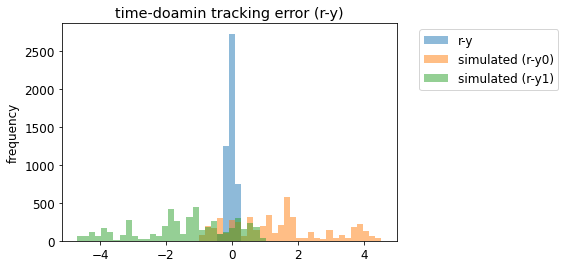

In [194]:

bins=np.histogram(np.hstack(((r-y).flatten(),(r-y0).flatten(),(r-y1).flatten())), bins=50)[1] #get the bin edges
plt.hist((r-y).flatten(),bins,alpha=0.5,label = 'r-y')
plt.hist((r-y0).flatten(),bins,alpha=0.5,label = 'simulated (r-y0)')
plt.hist((r-y1).flatten(),bins,alpha=0.5,label = 'simulated (r-y1)')

plt.title('time-doamin tracking error (r-y)')
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

## distributions in mag and phase (TYR,TYD)


In [ ]:
# number of trials to look at of each condition: (ex: last 4)
last_trial = [8,8,8,8,8,4,4]

# what freqs to look at over all 8 stim freqs: (ex: [0,1,2,3,4,5,6,7])
first_freq = [0,1]

plot_title = 'first 2 freqs' #'all freqs'

In [ ]:
mag0 = []
mag1 = []
for c in range(participants_num):
    mag0.append(abs(TF['TY0D']['subject'+str(c)]['condition2'][-(last_trial[2]//2):][:,first_freq]))
    mag1.append(abs(TF['TY1D']['subject'+str(c)]['condition2'][-(last_trial[2]//2):][:,first_freq]))
mag0 = np.asarray(mag0)
mag1 = np.asarray(mag1)

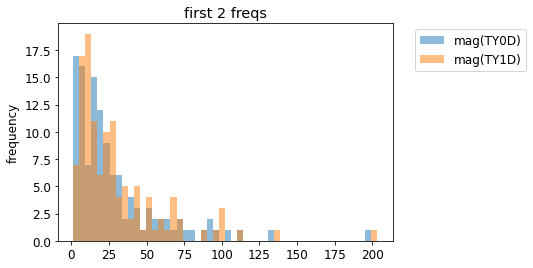

In [ ]:
bins=np.histogram(np.hstack((mag0.flatten(),mag1.flatten())), bins=50)[1] #get the bin edges
plt.hist(mag0.flatten(),bins,alpha=0.5,label = 'mag(TY0D)')
plt.hist(mag1.flatten(),bins,alpha=0.5,label = 'mag(TY1D)')

plt.title(plot_title)
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

In [ ]:
phase0 = []
phase1 = []
for c in range(participants_num):
    phase0.append(np.angle(TF['TY0D']['subject'+str(c)]['condition2'][-(last_trial[2]//2):][:,first_freq]))
    phase1.append(np.angle(TF['TY1D']['subject'+str(c)]['condition2'][-(last_trial[2]//2):][:,first_freq]))
phase0 = np.asarray(phase0)
phase1 = np.asarray(phase1)


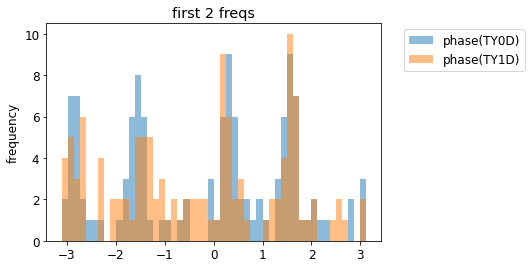

In [ ]:
bins=np.histogram(np.hstack((phase0.flatten(),phase1.flatten())), bins=50)[1] #get the bin edges
plt.hist(phase0.flatten(),bins,alpha=0.5,label = 'phase(TY0D)')
plt.hist(phase1.flatten(),bins,alpha=0.5,label = 'phase(TY1D)')

plt.title(plot_title)
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

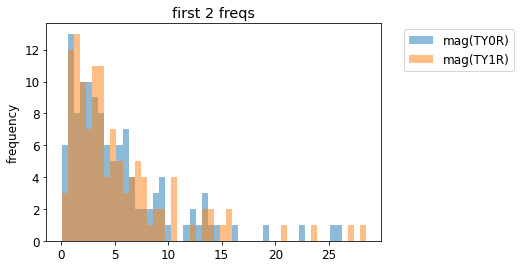

In [ ]:
mag0 = []
mag1 = []
for c in range(participants_num):
    mag0.append(abs(TF['TY0R']['subject'+str(c)]['condition2'][-(last_trial[2]//2):][:,first_freq]))
    mag1.append(abs(TF['TY1R']['subject'+str(c)]['condition2'][-(last_trial[2]//2):][:,first_freq]))
mag0 = np.asarray(mag0)
mag1 = np.asarray(mag1)

bins=np.histogram(np.hstack((mag0.flatten(),mag1.flatten())), bins=50)[1] #get the bin edges
plt.hist(mag0.flatten(),bins,alpha=0.5,label = 'mag(TY0R)')
plt.hist(mag1.flatten(),bins,alpha=0.5,label = 'mag(TY1R)')

plt.title(plot_title)
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 